In [ ]:
!pip install node2vec

In [ ]:
# Physical Topology and Demand Topology (Private Networkx Attributed Graphs)
from bt_fibre_graph_july_2024 import create_BT_106_graph
from bt_demand_graph_september_2024 import create_bt_demand_graph

# Import necessary libraries
import pandas as pd
import networkx as nx
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.special

# Scikit-learn libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputRegressor

# Statsmodels
import statsmodels.api as sm

# Node2Vec
from node2vec import Node2Vec

# # Function to set random seeds for reproducibility
# def set_random_seed(seed=42):
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)

# # We will set this seed at the top of the notebook for consistency
# set_random_seed()

In [ ]:
def load_BT_traffic(filepath='raw_traffic_bt_sorted.csv'):
  # Load the traffic data
  traffic_data = pd.read_csv(filepath)

  # Append Total Traffic
  traffic_data['TotalTraffic'] = traffic_data['TrafficA2B'] + traffic_data['TrafficB2A']

  # Save the updated dataset
  traffic_data.to_csv('traffic_data_with_total.csv', index=False)

  return traffic_data

def load_BT_fibre_topology():
  # Create the graph
  G = create_BT_106_graph()
  return G

def load_BT_demand_topology():
  G = create_bt_demand_graph()
  return G

def extract_attributes_and_metrics(G, traffic_data):
    # Extract node locations, number of datacenters, ixps and population along with graph metrics at the nodal level
    data = []

    for _, row in traffic_data.iterrows():
        A, B = row['SiteA'], row['SiteB']

        # Get source and destination nodes
        node_a_data = G.nodes[A]
        node_b_data = G.nodes[B]

        # Compute shortest path length in terms of kilometers
        shortest_path_length = nx.shortest_path_length(G, source=A, target=B, weight='weight')

        # Compute shortest path length in hops
        shortest_path_length_hops = nx.shortest_path_length(G, source=A, target=B)

        # Compute average shortest path length in terms of kilometers
        average_shortest_path_length = nx.average_shortest_path_length(G)

        # Compute average node degree of the complete graph
        average_node_degree = sum(dict(G.degree()).values()) / len(G.nodes)

        # Compute diameter of graph
        diameter = nx.diameter(G)

        # Compute density of graph
        density = nx.density(G)

        # Compute number of nodes and edges
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()

        # Compute the normalized Laplacian spectrum once
        normalized_laplacian_spectrum = np.linalg.eigvals(nx.normalized_laplacian_matrix(G).toarray())

        # Compute the second smallest value of the normalized Laplacian (algebraic connectivity)
        normalized_laplacian_min = np.sort(normalized_laplacian_spectrum)[1]  # Greater than 0 but minimal value

        # Compute the largest value of the normalized Laplacian
        normalized_laplacian_max = normalized_laplacian_spectrum.max()

        # Compute the node betweenness centrality
        betweenness_centrality = nx.betweenness_centrality(G, weight='weight')

        # Compute population product
        population_product = node_a_data['total_population'] * node_b_data['total_population']

        # Compute source and destination node degree
        node_degree_a = G.degree[A]
        node_degree_b = G.degree[B]

        # Compute node degree product
        node_degree_product = node_degree_a * node_degree_b

        # Compute node degree ratio
        node_degree_ratio = node_degree_a / node_degree_b

        # Compute the sum of IXP at node a and b
        ixp_sum = node_a_data['num_ixp'] + node_b_data['num_ixp']

        # Compute the sum of DC at node a and b
        dc_sum = node_a_data['num_dc'] + node_b_data['num_dc']

        # Compute the absolute difference of IXP at node a and b
        ixp_difference = abs(node_a_data['num_ixp'] - node_b_data['num_ixp'])

        # Compute the absolute difference of DC at node a and b
        dc_difference = abs(node_a_data['num_dc'] - node_b_data['num_dc'])

        # Compute the binomial expression based on the node degree of a and b
        binomial_expression = (node_degree_a + node_degree_b) * (node_degree_a - 1) * (node_degree_b - 1)

        # Compute the effect of this
        binomial_expression_avg = binomial_expression / (num_nodes * (num_nodes - 1))

        if G.has_edge(A, B):
            edge_data = G.get_edge_data(A, B)
        else:
            edge_data = None

        data.append([
                node_a_data['lat'],
                node_a_data['long'],
                node_b_data['lat'],
                node_b_data['long'],
                1.0 if edge_data!=None else 0.0,
                node_a_data['num_dc'],
                node_b_data['num_dc'],
                dc_sum,
                dc_difference,
                node_a_data['num_ixp'],
                node_b_data['num_ixp'],
                ixp_sum,
                ixp_difference,
                node_a_data['total_population'],
                node_b_data['total_population'],
                population_product,
                node_degree_product,
                node_degree_ratio,
                binomial_expression,
                binomial_expression_avg,
                shortest_path_length,
                shortest_path_length_hops,
                G.degree[A],
                G.degree[B],
                average_node_degree,
                diameter,
                num_nodes,
                num_edges,
                density,
                average_shortest_path_length,
                betweenness_centrality[A],
                betweenness_centrality[B]

            ])
    return data



def get_BT_dataset_traffic_topology():
    G = load_BT_fibre_topology()
    traffic_data = load_BT_traffic()
    attributes = extract_attributes_and_metrics(G, traffic_data)

    attributes_df = pd.DataFrame(attributes, columns=[
    'LatA',
    'LongA',
    'LatB',
    'LongB',
    'isConnectedWithFibre',
    'NumDCatA',
    'NumDCatB',
    'SumDCatAandB',
    'DifferenceDCatAandB',
    'NumIXPatA',
    'NumIXPatB',
    'SumIXPatAandB',
    'DifferenceIXPatAandB',
    'PopulationA',
    'PopulationB',
    'PopulationProduct',
    'NodeDegreeProduct',
    'NodeDegreeRatio',
    'BinomialExpressionNodeDegreeAB',
    'BinomialExpressionNodeDegreeABAvg',
    'ShortestPathLength',
    'ShortestPathLengthHops',
    'NodeDegreeA',
    'NodeDegreeB',
    'AverageNodeDegreeGraph',
    'DiameterGraph',
    'NumNodesGraph',
    'NumEdgesGraph',
    'DensityGraph',
    'AverageShortestPathLength',
    'NodeBetweenessA',
    'NodeBetweenessB'
    ])

    # Append the extracted attributes and metrics to the traffic data
    final_data = pd.concat([traffic_data, attributes_df], axis=1)

    # Add geographic distance
    lat_long_columns = [('LatA', 'LongA'), ('LatB', 'LongB')]
    final_data = add_geographical_distance(final_data, lat_long_columns)

    # Normalise total traffic
    final_data = normalise_traffic(final_data)

    # Save the final dataset
    final_data.to_csv('final_data_bt_lat_long_traffic_dc_ixp_pop_path_node_degree_btw.csv', index=False)

    return final_data



def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of latitudes and longitudes.
    """
    R = 6371  # Earth radius in kilometers

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

def add_geographical_distance(final_data, lat_long_columns):

    final_data_update = final_data.copy()

    # Compute the Haversine distance between Site A and Site B
    final_data_update['HaversineDistance'] = haversine_distance(
        final_data[lat_long_columns[0][0]],
        final_data[lat_long_columns[0][1]],
        final_data[lat_long_columns[1][0]],
        final_data[lat_long_columns[1][1]]
    )

    return final_data_update


def get_X_and_y_data():
    final_data = get_BT_dataset_traffic_topology()
    input_data_df = final_data

    # The dataset after removing prediction columns
    X = input_data_df.drop(columns=['TotalTraffic', 'TrafficA2B', 'TrafficB2A'])
    y = input_data_df['TotalTraffic']

    X.to_csv('X.csv', index=False)
    y.to_csv('y.csv', index=False)

    return final_data, X, y


def get_mean_baseline(y, final_data):
    y_pred_mean = y.mean() * np.ones(y.shape)
    final_data['MeanBaseline'] = y_pred_mean
    return y_pred_mean

def get_median_baseline(y, final_data):
    y_pred_median = np.median(y) * np.ones(y.shape)
    final_data['MedianBaseline'] = y_pred_median
    return y_pred_median

def normalize_population(population, min_population, max_population):
    return (population - min_population) / (max_population - min_population)

def get_OFC_2000_baseline_Dwivedi_et_al(final_data):

    # Population Data
    population_A = final_data['PopulationA']
    population_B = final_data['PopulationB']

    # Get min and max of population assigned to each node
    min_population = min(population_A.min(), population_B.min())
    max_population = max(population_A.max(), population_B.max())

    # Normalize populations
    normalized_population_A = normalize_population(population_A, min_population, max_population)
    normalized_population_B = normalize_population(population_B, min_population, max_population)

    final_data['NormalizedPopulationA'] = normalized_population_A
    final_data['NormalizedPopulationB'] = normalized_population_B

    # UK has a high internet penetration rate, with nearly 98% of the population using the internet as of January 2024.
    internet_users_A = 0.98 * normalized_population_A
    internet_users_B = 0.98 * normalized_population_B

    final_data['InternetUsersA'] = internet_users_A
    final_data['InternetUsersB'] = internet_users_B

    # Geographical Distance between two sites
    haversine_distance_A_B = final_data['HaversineDistance']

    # Based on Population
    y_pred_population_product = normalized_population_A * normalized_population_B
    y_pred_population_product_divided_by_distance = normalized_population_A * normalized_population_B / haversine_distance_A_B
    y_pred_population_product_divided_by_sqrt_distance = normalized_population_A * normalized_population_B / np.sqrt(haversine_distance_A_B)

    # Based on Internet Users
    y_pred_internet_users_product = internet_users_A * internet_users_B
    y_pred_internet_users_product_divided_by_distance  = internet_users_A * internet_users_B / haversine_distance_A_B
    y_pred_internet_users_product_divided_by_sqrt_distance = internet_users_A * internet_users_B / np.sqrt(haversine_distance_A_B)

    final_data['OFC_traffic_population_product'] = y_pred_population_product
    final_data['OFC_traffic_population_product_divided_by_distance'] = y_pred_population_product_divided_by_distance
    final_data['OFC_traffic_population_product_divided_by_sqrt_distance'] = y_pred_population_product_divided_by_sqrt_distance
    final_data['OFC_traffic_internet_users_product'] = y_pred_internet_users_product
    final_data['OFC_traffic_internet_users_product_divided_by_distance'] = y_pred_internet_users_product_divided_by_distance
    final_data['OFC_traffic_internet_users_product_divided_by_sqrt_distance'] = y_pred_population_product_divided_by_sqrt_distance

    return final_data, y_pred_population_product, y_pred_population_product_divided_by_distance, y_pred_population_product_divided_by_sqrt_distance, y_pred_internet_users_product, y_pred_internet_users_product_divided_by_distance, y_pred_internet_users_product_divided_by_sqrt_distance


def get_ECOC_2020_baseline_Patri_et_al(final_data):
    # Assuming A and B are source and destination
    combined_node_degree_N_AB = final_data['NodeDegreeA'] + final_data['NodeDegreeB']
    average_node_degree_graph = final_data['AverageNodeDegreeGraph']

    # Update
    final_data['SumNodeDegreeAB'] = combined_node_degree_N_AB

    # Get number of DC and IXP at each source and destination
    num_dc_at_A = final_data['NumDCatA']
    num_dc_at_B = final_data['NumDCatB']
    num_iXP_at_A = final_data['NumIXPatA']
    num_iXP_at_B = final_data['NumIXPatB']

    # Compute the absolute difference between the two
    delta_A = abs(num_dc_at_A - num_iXP_at_A)
    delta_B = abs(num_dc_at_B - num_iXP_at_B)

    # Update
    final_data['DeltaA'] = delta_A
    final_data['DeltaB'] = delta_B

    # Initialize traffic series
    traffic = pd.Series(index=final_data.index, dtype=float)

    # Condition check for each row in the DataFrame
    condition = combined_node_degree_N_AB > 2 * average_node_degree_graph

    # Calculate traffic based on the condition
    traffic[condition] = 2 * scipy.special.comb(combined_node_degree_N_AB[condition], 2) * delta_A[condition] * delta_B[condition]
    traffic[~condition] = combined_node_degree_N_AB[~condition] * delta_A[~condition] * delta_B[~condition]

    # Update the final_data with prior methods
    final_data['ECOC_traffic'] = traffic

    return final_data, traffic


def normalise_traffic(final_data):
    traffic = final_data['TotalTraffic']
    normalised_traffic = (traffic - traffic.min()) / (traffic.max() - traffic.min())
    final_data['NormalisedTotalTraffic'] = normalised_traffic
    return final_data

def load_BT_fibre_topology():
  # Create the graph
  G = create_BT_106_graph()
  return G

def load_BT_demand_topology():
  G = create_bt_demand_graph()
  return G

def extract_attributes_and_metrics_for_demand_graph(G, traffic_data):
    # Extract node locations, number of datacenters, ixps and population along with graph metrics at the nodal level
    data = []

    for _, row in traffic_data.iterrows():
        A, B = row['SiteA'], row['SiteB']

        # Get source and destination nodes
        node_a_data = G.nodes[A]
        node_b_data = G.nodes[B]

        # Compute shortest path length in terms of minimising total traffic
        shortest_path_length = nx.shortest_path_length(G, source=A, target=B, weight='totaltraffic')

        # Compute shortest path length in hops
        shortest_path_length_hops = nx.shortest_path_length(G, source=A, target=B)

        # Compute average shortest path length in terms of kilometers
        average_shortest_path_length = nx.average_shortest_path_length(G)

        # Compute average node degree of the complete graph
        average_node_degree = sum(dict(G.degree()).values()) / len(G.nodes)

        # Compute diameter of graph
        diameter = nx.diameter(G)

        # Compute density of graph
        density = nx.density(G)

        # Compute number of nodes and edges
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()

        # Compute the normalized Laplacian spectrum once
        normalized_laplacian_spectrum = np.linalg.eigvals(nx.normalized_laplacian_matrix(G).toarray())

        # Compute the second smallest value of the normalized Laplacian (algebraic connectivity)
        normalized_laplacian_min = np.sort(normalized_laplacian_spectrum)[1]  # Greater than 0 but minimal value

        # Compute the largest value of the normalized Laplacian
        normalized_laplacian_max = normalized_laplacian_spectrum.max()

        # Compute the node betweenness centrality
        betweenness_centrality = nx.betweenness_centrality(G, weight='totaltraffic')

        # Compute population product
        population_product = node_a_data['total_population'] * node_b_data['total_population']

        # Compute source and destination node degree
        node_degree_a = G.degree[A]
        node_degree_b = G.degree[B]

        # Compute node degree product
        node_degree_product = node_degree_a * node_degree_b

        # Compute node degree ratio
        node_degree_ratio = node_degree_a / node_degree_b

        # Compute the sum of IXP at node a and b
        ixp_sum = node_a_data['num_ixp'] + node_b_data['num_ixp']

        # Compute the sum of DC at node a and b
        dc_sum = node_a_data['num_dc'] + node_b_data['num_dc']

        # Compute the absolute difference of IXP at node a and b
        ixp_difference = abs(node_a_data['num_ixp'] - node_b_data['num_ixp'])

        # Compute the absolute difference of DC at node a and b
        dc_difference = abs(node_a_data['num_dc'] - node_b_data['num_dc'])

        # Compute the binomial expression based on the node degree of a and b
        binomial_expression = (node_degree_a + node_degree_b) * (node_degree_a - 1) * (node_degree_b - 1)

        # Compute the effect of this
        binomial_expression_avg = binomial_expression / (num_nodes * (num_nodes - 1))

        if G.has_edge(A, B):
            edge_data = G.get_edge_data(A, B)
        else:
            edge_data = None

        data.append([
                node_a_data['lat'],
                node_a_data['long'],
                node_b_data['lat'],
                node_b_data['long'],
                1.0 if edge_data!=None else 0.0,
                node_a_data['num_dc'],
                node_b_data['num_dc'],
                dc_sum,
                dc_difference,
                node_a_data['num_ixp'],
                node_b_data['num_ixp'],
                ixp_sum,
                ixp_difference,
                node_a_data['total_population'],
                node_b_data['total_population'],
                population_product,
                node_degree_product,
                node_degree_ratio,
                binomial_expression,
                binomial_expression_avg,
                shortest_path_length,
                shortest_path_length_hops,
                G.degree[A],
                G.degree[B],
                average_node_degree,
                diameter,
                num_nodes,
                num_edges,
                density,
                average_shortest_path_length,
                betweenness_centrality[A],
                betweenness_centrality[B]

            ])
    return data



def get_BT_demand_graph_dataset_traffic_topology():
    G = load_BT_demand_topology()
    traffic_data = load_BT_traffic()
    attributes = extract_attributes_and_metrics_for_demand_graph(G, traffic_data)

    attributes_df = pd.DataFrame(attributes, columns=[
    'LatA',
    'LongA',
    'LatB',
    'LongB',
    'isConnectedWithFibre',
    'NumDCatA',
    'NumDCatB',
    'SumDCatAandB',
    'DifferenceDCatAandB',
    'NumIXPatA',
    'NumIXPatB',
    'SumIXPatAandB',
    'DifferenceIXPatAandB',
    'PopulationA',
    'PopulationB',
    'PopulationProduct',
    'NodeDegreeProduct',
    'NodeDegreeRatio',
    'BinomialExpressionNodeDegreeAB',
    'BinomialExpressionNodeDegreeABAvg',
    'ShortestPathLength',
    'ShortestPathLengthHops',
    'NodeDegreeA',
    'NodeDegreeB',
    'AverageNodeDegreeGraph',
    'DiameterGraph',
    'NumNodesGraph',
    'NumEdgesGraph',
    'DensityGraph',
    'AverageShortestPathLength',
    'NodeBetweenessA',
    'NodeBetweenessB'
    ])

    # Append the extracted attributes and metrics to the traffic data
    final_data = pd.concat([traffic_data, attributes_df], axis=1)

    # Add geographic distance
    lat_long_columns = [('LatA', 'LongA'), ('LatB', 'LongB')]
    final_data = add_geographical_distance(final_data, lat_long_columns)

    # Normalise total traffic
    final_data = normalise_traffic(final_data)

    # Save the final dataset
    final_data.to_csv('final_data_bt_lat_long_traffic_dc_ixp_pop_path_node_degree_btw.csv', index=False)

    return final_data


def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of latitudes and longitudes.
    """
    R = 6371  # Earth radius in kilometers

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

def add_geographical_distance(final_data, lat_long_columns):

    final_data_update = final_data.copy()

    # Compute the Haversine distance between Site A and Site B
    final_data_update['HaversineDistance'] = haversine_distance(
        final_data[lat_long_columns[0][0]],
        final_data[lat_long_columns[0][1]],
        final_data[lat_long_columns[1][0]],
        final_data[lat_long_columns[1][1]]
    )

    return final_data_update


def get_X_and_y_data_for_demand_graph():
    final_data = get_BT_demand_graph_dataset_traffic_topology()
    input_data_df = final_data

    # The dataset after removing prediction columns
    X = input_data_df.drop(columns=['TotalTraffic', 'TrafficA2B', 'TrafficB2A'])
    y = input_data_df['TotalTraffic']

    X.to_csv('X.csv', index=False)
    y.to_csv('y.csv', index=False)

    return final_data, X, y

def plot_linear_regression_learning_curve(X_train, y_train, X_test, y_test):
    train_sizes = np.linspace(0.1, 0.9, 9)
    train_mse_list = []
    test_mse_list = []
    train_rmse_list = []
    test_rmse_list = []
    train_mae_list = []
    test_mae_list = []
    coefficients = []
    y_train_pred_list = []
    y_test_pred_list = []

    for train_size in train_sizes:
        X_train_part, _, y_train_part, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)

        model = LinearRegression()
        model.fit(X_train_part, y_train_part)
        y_train_pred = model.predict(X_train_part)
        y_test_pred = model.predict(X_test)
        y_train_pred_list.append(y_train_pred)
        y_test_pred_list.append(y_test_pred)

        train_mse = mean_squared_error(y_train_part, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mae = mean_absolute_error(y_train_part, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        train_mse_list.append(train_mse)
        test_mse_list.append(test_mse)
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_mae_list.append(train_mae)
        test_mae_list.append(test_mae)

    # MSE Plot
    plt.figure(figsize=(10, 8))
    plt.plot(train_sizes, train_mse_list, label='Training MSE', marker='o', linewidth=3, markersize=10)
    plt.plot(train_sizes, test_mse_list, label='Testing MSE', marker='o', linewidth=3, markersize=10)
    plt.xlabel('Training Size', fontsize=20)
    plt.ylabel('Mean Squared Error', fontsize=20)
    plt.title('Learning Curves for Linear Regression', fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

    # RMSE Plot
    plt.figure(figsize=(10, 8))
    plt.plot(train_sizes, train_rmse_list, label='Training RMSE', marker='o', linewidth=3, markersize=10)
    plt.plot(train_sizes, test_rmse_list, label='Testing RMSE', marker='o', linewidth=3, markersize=10)
    plt.xlabel('Training Size', fontsize=20)
    plt.ylabel('Root Mean Squared Error', fontsize=20)
    plt.title('Learning Curves for Linear Regression (RMSE)', fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

    # MAE Plot
    plt.figure(figsize=(10, 8))
    plt.plot(train_sizes, train_mae_list, label='Training MAE', marker='o', linewidth=3, markersize=10)
    plt.plot(train_sizes, test_mae_list, label='Testing MAE', marker='o', linewidth=3, markersize=10)
    plt.xlabel('Training Size', fontsize=20)
    plt.ylabel('Mean Absolute Error', fontsize=20)
    plt.title('Learning Curves for Linear Regression (MAE)', fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

    results = {
        'train_sizes': train_sizes,
        'train_mse': train_mse_list,
        'test_mse': test_mse_list,
        'train_rmse': train_rmse_list,
        'test_rmse': test_rmse_list,
        'train_mae': train_mae_list,
        'test_mae': test_mae_list,
        'coefficients': coefficients,
        'y_train_pred_list': y_train_pred_list,
        'y_test_pred_list': y_test_pred_list
    }

    return results


def get_node_embeddings(graph, dimensions=106, walk_length=30, num_walks=300, workers=4):
    node2vec = Node2Vec(graph, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Get node embeddings
    embeddings = {str(node): model.wv[str(node)] if str(node) in model.wv else model.wv[int(node)] for node in graph.nodes()}

    return embeddings

def create_edge_embeddings(node_embeddings, edge_list):
    edge_embeddings = {}

    for edge in edge_list:
        # Ensure the node identifiers are strings to match the node_embeddings keys
        node_a, node_b = str(int(edge[0])), str(int(edge[1]))

        # Get node embeddings
        emb_a = node_embeddings.get(node_a)
        emb_b = node_embeddings.get(node_b)

        # If either node is missing in the embeddings, skip this edge
        if emb_a is None or emb_b is None:
            print(f"Missing embeddings for nodes: {node_a}, {node_b}")
            continue

        # Perform operations for edge embeddings
        average = (emb_a + emb_b) / 2
        summation = emb_a + emb_b
        hadamard_product = np.multiply(emb_a, emb_b)
        dot_product = np.dot(emb_a, emb_b)

        edge_embeddings[(node_a, node_b)] = {
            'average': average,
            'sum': summation,
            'hadamard_product': hadamard_product,
            'dot_product': dot_product
        }

    return edge_embeddings

def compute_dot_product(row, node_embeddings):
    node_a, node_b = str(int(row['SiteA'])), str(int(row['SiteB']))  # Convert nodes to string after converting to int

    # Ensure both nodes exist in the node embeddings
    if node_a in node_embeddings and node_b in node_embeddings:
        emb_a = node_embeddings[node_a]
        emb_b = node_embeddings[node_b]

        # Compute dot product
        dot_product = np.dot(emb_a, emb_b)
        return dot_product
    else:
        return np.nan  # Return NaN if either node is not found in embeddings



def plot_actual_vs_predicted(y_true, y_pred, color='blue', title="Actual vs Predicted Values"):
    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot the scatter plot of actual vs predicted
    plt.scatter(y_true, y_pred, color=color, alpha=0.5, s=100)

    # Plot the perfect prediction line
    max_value = max(y_true.max(), y_pred.max())
    min_value = min(y_true.min(), y_pred.min())
    plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', linewidth=3, alpha=0.5, label='Perfect Prediction')

    plt.xlabel('Actual Traffic', fontsize=24)
    plt.ylabel('Predicted Traffic', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=24)
    plt.grid(True, alpha=0.3)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


def process_demand_graph_and_add_embeddings(final_data_demand_graph):
    """
    This function creates the demand graph, computes node embeddings, converts the edge list,
    creates edge embeddings, and adds these embeddings to the final data DataFrame.

    Parameters:
    - final_data_demand_graph: A pandas DataFrame to which edge embeddings will be added.

    Returns:
    - final_data_demand_graph: The DataFrame with a new column 'edge_embedding'.
    """
    # Create demand graph
    G = create_bt_demand_graph()

    # Get node embeddings
    node_embeddings = get_node_embeddings(G)

    # Get the edge list and convert float node IDs to integers
    edge_list = G.edges()
    converted_edge_list = [(int(a), int(b)) for a, b in edge_list]

    # Create edge embeddings
    edge_embeddings = create_edge_embeddings(node_embeddings, converted_edge_list)

    # Add the 'edge_embedding' column by applying the function to each row
    final_data_demand_graph['edge_embedding'] = final_data_demand_graph.apply(
        lambda row: compute_dot_product(row, node_embeddings), axis=1)

    return final_data_demand_graph

def process_fiber_graph_and_add_edge_embeddings(final_data_fibre_graph):
    """
    This function creates a BT fiber graph, computes node embeddings, converts the edge list,
    creates edge embeddings, and adds these embeddings as a column to the provided DataFrame.

    Parameters:
    - final_data_fibre_graph: A pandas DataFrame to which fiber edge embeddings will be added.

    Returns:
    - final_data_fibre_graph: The DataFrame with a new column 'fibre_edge_embedding'.
    """
    # Step 1: Create BT fiber graph
    G = create_BT_106_graph()

    # Step 2: Get node embeddings
    node_embeddings_fibre = get_node_embeddings(G)

    # Step 3: Get the edge list and convert float node IDs to integers
    edge_list = G.edges()
    converted_edge_list = [(int(a), int(b)) for a, b in edge_list]

    # Step 4: Compute edge embeddings
    edge_embeddings = create_edge_embeddings(node_embeddings_fibre, converted_edge_list)

    # Step 5: Add the 'fibre_edge_embedding' column to the dataframe
    final_data_fibre_graph['fibre_edge_embedding'] = final_data_fibre_graph.apply(
        lambda row: compute_dot_product(row, node_embeddings_fibre), axis=1)

    return final_data_fibre_graph

def process_data(final_data_fibre_graph, final_data_demand_graph):
    """
    This function processes the data by extracting relevant features, combining the datasets,
    and splitting them into training and test sets.

    Returns:
    - X_train, X_test: The train and test sets for independent variables (features).
    - y_train, y_test: The train and test sets for the dependent variable (target).
    """
    # Extract features from fibre graph data
    X_fibre = final_data_fibre_graph[['ShortestPathLength', 'ShortestPathLengthHops', 'NodeDegreeA',
                                      'NodeDegreeB', 'NodeBetweenessA', 'NodeBetweenessB',
                                      'fibre_edge_embedding', 'NodeDegreeProduct',
                                      'BinomialExpressionNodeDegreeAB']]

    # Extract features from demand graph data
    X_demand = final_data_demand_graph[['LatA', 'LongA', 'LatB', 'LongB', 'isConnectedWithFibre',
                                        'NumDCatA', 'NumDCatB', 'NumIXPatA', 'NumIXPatB',
                                        'PopulationA', 'PopulationB', 'ShortestPathLength',
                                        'ShortestPathLengthHops', 'NodeDegreeA', 'NodeDegreeB',
                                        'NodeBetweenessA', 'NodeBetweenessB', 'HaversineDistance',
                                        'edge_embedding']]

    # Merge fibre and demand data based on common indices (or use keys like 'SiteA' and 'SiteB' if available)
    X_combined = pd.merge(X_fibre, X_demand, left_index=True, right_index=True, how='inner')

    # Define the dependent variable
    y_combined = final_data_demand_graph['NormalisedTotalTraffic']

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.7, random_state=42)

    return X_combined, y_combined, X_train, X_test, y_train, y_test

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """
    This function trains a linear regression model and evaluates it on both the train and test sets.

    It returns the predictions and prints evaluation metrics and feature coefficients.

    Parameters:
    - X_train, X_test: Train and test sets for independent variables.
    - y_train, y_test: Train and test sets for the dependent variable.

    Returns:
    - y_test_pred: Predictions on the test set.
    - coefficients: Model coefficients.
    """
    # Define Linear Regression model
    model = LinearRegression()

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Save the predicted and actual values
    pd.DataFrame({
        'Actual_traffic': y_test,
        'Graphmind_lr_predicted_traffic': y_test_pred
    }).to_csv('graphmind_lr_predicted_data.csv', index=False)

    # Get model coefficients
    coefficients = model.coef_

    # Calculate the evaluation metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Print the metrics
    print("--------EVALUATION---------------")
    print(f"Train MSE: {train_mse}")
    print(f"Test MSE: {test_mse}")
    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")
    print(f"Train MAE: {train_mae}")
    print(f"Test MAE: {test_mae}")

    # Print feature names and coefficients
    print("---------FEATURE COEFF--------------")
    for feature, coef in zip(X_train.columns, coefficients):
        print(f"{feature}: {coef}")

    return y_test_pred, coefficients

def find_optimal_training_size(X_combined, y_combined, test_sizes):
    """
    Finds the optimal training size by running linear regression for different test sizes and calculating error metrics.

    Parameters:
    - X_combined: Combined feature matrix.
    - y_combined: Target variable.
    - test_sizes: A list of test sizes to iterate over.

    Returns:
    - train_sizes_list: List of training sizes.
    - test_mse_list: List of Mean Squared Errors for the test set.
    - test_rmse_list: List of Root Mean Squared Errors for the test set.
    - test_mae_list: List of Mean Absolute Errors for the test set.
    """
    # Lists to store the results for plotting
    train_sizes_list = []
    test_mse_list = []
    test_rmse_list = []
    test_mae_list = []

    # Loop through each test size
    for test_size in test_sizes:
        print(f"Running Linear Regression for test_size={test_size}")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=test_size, random_state=42)

        # Define Linear Regression model
        model = LinearRegression()

        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate the metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # Store the results
        train_sizes_list.append(1 - test_size)  # Since test_size + train_size = 1
        test_mse_list.append(test_mse)
        test_rmse_list.append(test_rmse)
        test_mae_list.append(test_mae)

        # Print the evaluation metrics
        print("--------EVALUATION---------------")
        print(f"Test Size: {test_size}")
        print(f"Train MSE: {train_mse}")
        print(f"Test MSE: {test_mse}")
        print(f"Train RMSE: {np.sqrt(train_mse)}")
        print(f"Test RMSE: {test_rmse}")
        print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred)}")
        print(f"Test MAE: {test_mae}")
        print("----------------------------------------------\n")

    return train_sizes_list, test_mse_list, test_rmse_list, test_mae_list

def plot_training_size_vs_errors(train_sizes_list, test_mse_list, test_rmse_list, test_mae_list):
    """
    Plots the error metrics (MSE, RMSE, MAE) against different training sizes.

    Parameters:
    - train_sizes_list: List of training sizes.
    - test_mse_list: List of Mean Squared Errors for the test set.
    - test_rmse_list: List of Root Mean Squared Errors for the test set.
    - test_mae_list: List of Mean Absolute Errors for the test set.
    """
    # Plotting the results
    plt.figure(figsize=(12, 8))  # Increase the figure size

    plt.plot(train_sizes_list, test_mse_list, label='Test MSE', marker='o', linewidth=3, color='green', markersize=10)
    plt.plot(train_sizes_list, test_rmse_list, label='Test RMSE', marker='o', linewidth=3, color='red', markersize=10)
    plt.plot(train_sizes_list, test_mae_list, label='Test MAE', marker='o', linewidth=3, color='blue', markersize=10)

    plt.xlabel('Training Size', fontsize=20)
    plt.ylabel('Error', fontsize=20)
    plt.ylim(ymin=0, ymax=max(test_mse_list + test_rmse_list + test_mae_list) * 1.1)

    # Customize y-axis ticks for smaller step size
    plt.yticks(np.arange(0, 0.6, 0.1))  # Step size of 0.05 between ticks

    plt.margins(x=0.05, y=0.1)  # Add some margin to both x and y axes
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout(pad=3.0)
    plt.show()


def save_metrics_to_csv(train_sizes_list, test_mse_list, test_rmse_list, test_mae_list, filename='training_size_vs_error_metrics.csv'):
    """
    Saves the training sizes and corresponding error metrics to a CSV file.

    Parameters:
    - train_sizes_list: List of training sizes.
    - test_mse_list: List of Test Mean Squared Errors.
    - test_rmse_list: List of Test Root Mean Squared Errors.
    - test_mae_list: List of Test Mean Absolute Errors.
    - filename: The name of the CSV file to save (default: 'training_size_vs_error_metrics.csv').

    Returns:
    - None. The results are saved to a CSV file.
    """
    # Create a dictionary from the lists
    results_dict = {
        'Training Size': train_sizes_list,
        'Test MSE': test_mse_list,
        'Test RMSE': test_rmse_list,
        'Test MAE': test_mae_list
    }

    # Convert the dictionary into a pandas DataFrame
    results_df = pd.DataFrame(results_dict)

    # Save the DataFrame to a CSV file
    results_df.to_csv(filename, index=False)

    print(f"Results saved to {filename}")


def save_and_store_graphmind_lr_data(X_combined, y_combined, X_test, y_test, y_test_pred, prefix='graphmind_lr', date='23_October'):
    """
    Saves the combined dataset, test set, and predictions to CSV files and stores them in variables.

    Parameters:
    - X_combined: Combined input features (fibre + demand graph features).
    - y_combined: Combined output (target) variable.
    - X_test: Test set input features.
    - y_test: Test set output (target) variable.
    - y_test_pred: Predictions on the test set.
    - prefix: A string prefix for the file names (default: 'graphmind_lr').
    - date: A string representing the date for the file names (default: '23_October').

    Returns:
    - A dictionary containing the stored DataFrames (inputs, outputs, predictions).
    """
    # Save the data to CSV files
    X_combined.to_csv(f'{prefix}_X_combined_{date}.csv', index=False)
    y_combined.to_csv(f'{prefix}_y_combined_{date}.csv', index=False)
    X_test.to_csv(f'{prefix}_X_test_{date}.csv', index=False)
    y_test.to_csv(f'{prefix}_y_test_{date}.csv', index=False)

    # Convert y_test_pred to a pandas DataFrame
    y_test_pred_df = pd.DataFrame(y_test_pred, columns=['Predicted'])

    # Save the predictions as a CSV file
    y_test_pred_df.to_csv(f'{prefix}_y_test_pred_{date}.csv', index=False)

    # Store the data for future use
    stored_data = {
        'input': X_combined,
        'output': y_combined,
        'test_input': X_test,
        'test_output': y_test,
        'test_pred': y_test_pred_df
    }

    print(f"Data and predictions saved to files with prefix '{prefix}' and date '{date}'.")

    # Return the stored DataFrames for future use
    return stored_data

def get_feature_importance(X_combined, y_combined):
    """
    Fits a linear regression model on the provided dataset and returns a sorted DataFrame
    of feature importance based on the model's coefficients.

    Parameters:
    - X_combined: The combined input feature matrix.
    - y_combined: The target variable.

    Returns:
    - df_feature_importance: A pandas DataFrame containing feature names and their corresponding importance (coefficients),
                             sorted by importance in descending order.
    """
    # Define Linear Regression
    model = LinearRegression()

    # Fit the model
    model.fit(X_combined, y_combined)

    # Get model coefficients
    coefficients = model.coef_

    # Initialize the data structure to hold feature names and their corresponding coefficients.
    data = {
        'feature': X_combined.columns,  # Feature names from the dataset
        'importance': coefficients      # Corresponding coefficients from the model
    }

    # Create a DataFrame from the feature and importance data
    df_feature_importance = pd.DataFrame(data)

    # Sort the DataFrame by importance in descending order (optional)
    df_feature_importance = df_feature_importance.sort_values(by='importance', ascending=False)

    # Return the DataFrame
    return df_feature_importance


def get_top_5_features(df_feature_importance):
    """
    Separates the positive and negative feature importances, extracts the top 5 positive and
    top 5 negative features, and combines them into a single DataFrame sorted by importance.

    Parameters:
    - df_feature_importance: DataFrame containing feature names and their corresponding importance (coefficients).

    Returns:
    - top_5_combined: A DataFrame containing the top 5 positive and top 5 negative features sorted by importance.
    """
    # Separate positive and negative values
    positive_features = df_feature_importance[df_feature_importance['importance'] > 0]
    negative_features = df_feature_importance[df_feature_importance['importance'] < 0]

    # Sort the positive and negative features by absolute importance
    top_5_positive = positive_features.sort_values(by='importance', ascending=False).head(5)
    top_5_negative = negative_features.sort_values(by='importance', ascending=True).head(5)

    # Combine top 5 positive and top 5 negative features
    top_5_combined = pd.concat([top_5_positive, top_5_negative])

    # Sort the combined result by importance for plotting
    top_5_combined = top_5_combined.sort_values(by='importance', ascending=False)

    # Return the combined DataFrame
    return top_5_combined

def plot_feature_importance(top_5_combined):
    """
    Creates a horizontal bar plot for the top 5 positive and top 5 negative features based on their importance (coefficients).

    Parameters:
    - top_5_combined: A DataFrame containing feature names and their corresponding importance (coefficients).

    Returns:
    - None. Displays the plot.
    """
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the combined top 5 positive and negative features
    bars = ax.barh(
        top_5_combined['feature'],
        top_5_combined['importance'],
        color=['skyblue' if x > 0 else 'salmon' for x in top_5_combined['importance']],
        alpha=0.6
    )

    # Add value labels to the bars
    for bar in bars:
        ax.text(
            bar.get_width() + (0.05 if bar.get_width() > 0 else -0.05),
            bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.3f}',
            va='center',
            ha='right' if bar.get_width() > 0 else 'left',
            fontsize=19,
            color='black'
        )

    # Invert y-axis for better readability
    ax.invert_yaxis()

    # Set x and y labels and ticks
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Raw Coefficients', fontsize=20)
    plt.ylabel('Feature', fontsize=22)

    # Display the plot
    plt.show()

def rank_features_by_absolute_importance(top_5_combined):
    """
    Ranks the features by absolute importance (coefficients) in descending order.

    Parameters:
    - top_5_combined: A DataFrame containing feature names and their corresponding importance (coefficients).

    Returns:
    - df_ranked: A DataFrame containing the ranked features by absolute importance.
    """
    # Rank the features by absolute importance (descending)
    df_ranked = top_5_combined.reindex(top_5_combined['importance'].abs().sort_values(ascending=False).index)

    # Return the ranked DataFrame
    return df_ranked


def calculate_optimal_feature_metrics(X_top_list, y):
    """
    Iterates over each feature subset in X_top_list, trains a linear regression model, and calculates test metrics.

    Parameters:
    - X_top_list: A list of DataFrames, each containing a subset of features.
    - y: The target variable.

    Returns:
    - test_mse_list: List of test MSE values for each feature subset.
    - test_rmse_list: List of test RMSE values for each feature subset.
    - test_mae_list: List of test MAE values for each feature subset.
    """
    # Lists to store test metrics
    test_mse_list = []
    test_rmse_list = []
    test_mae_list = []

    # Iterate over each X_top dataset and fit the linear regression model
    for i, X_top in enumerate(X_top_list, 1):  # i starts from 1
        print(f"Running Linear Regression for X_top_{i}")

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.7, random_state=42)

        # Define Linear Regression model
        model = LinearRegression()

        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_test_pred = model.predict(X_test)

        # Calculate the test metrics
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test, y_test_pred)

        # Store the test metrics
        test_mse_list.append(test_mse)
        test_rmse_list.append(test_rmse)
        test_mae_list.append(test_mae)

        print(f"Test MSE for X_top_{i}: {test_mse}")
        print(f"Test RMSE for X_top_{i}: {test_rmse}")
        print(f"Test MAE for X_top_{i}: {test_mae}")
        print("----------------------------------------------")

    return test_mse_list, test_rmse_list, test_mae_list


# def plot_optimal_feature_metrics(test_mae_list):
#     """
#     Plots the test Mean Absolute Error (MAE) against the top k features.

#     Parameters:
#     - test_mae_list: List of MAE values for each feature subset.

#     Returns:
#     - None. Displays the plot.
#     """
#     # Top k features from 1 to 10
#     top_k = list(range(1, 11))
#     # Round the MAE values to 3 decimal places
#     test_mae_list_rounded = np.round(test_mae_list, 2)


#     # Plotting the test MAE
#     plt.figure(figsize=(12, 6))
#     plt.plot(top_k, test_mae_list_rounded, label='Test MAE', marker='o', linewidth=3, markersize=10, color='blue')

#     # Set labels and title
#     plt.xlabel('Top k Features', fontsize=20)
#     plt.ylabel('Mean Absolute Error (MAE)', fontsize=20)

#     # Add legend
#     plt.legend(fontsize=20)

#     # Customize ticks
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.xticks(range(1, 11, 1))  # Step size of 1

#     # Add grid
#     plt.grid(True, alpha=0.3)

#     # Adjust layout and show plot
#     plt.tight_layout()
#     plt.show()

def plot_optimal_feature_metrics(test_mae_list):
    """
    Plots the test Mean Absolute Error (MAE) against the top k features.

    Parameters:
    - test_mae_list: List of MAE values for each feature subset.

    Returns:
    - None. Displays the plot.
    """
    # Top k features from 1 to 10
    top_k = list(range(1, 11))

    # Round the MAE values to 3 decimal places for plotting
    test_mae_list_rounded = np.round(test_mae_list, 3)

    # Plotting the test MAE
    plt.figure(figsize=(12, 6))
    plt.plot(top_k, test_mae_list_rounded, label='Test MAE', marker='o', linewidth=3, markersize=10, color='blue')

    # Set labels and title
    plt.xlabel('Top k Features', fontsize=20)
    plt.ylabel('Mean Absolute Error (MAE)', fontsize=20)

    # Customize ticks
    plt.xticks(range(1, 11), fontsize=20)

    # Round the y-tick values to 3 decimal places
    plt.yticks(np.round(np.linspace(min(test_mae_list_rounded), max(test_mae_list_rounded), 5), 3), fontsize=20)

    # Add legend
    plt.legend(fontsize=20)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

def process_baseline_predictions(final_data_fibre_graph, y):
    """
    Processes baseline predictions, including mean and median baselines, OFC and ECOC predictions,
    handles NaN and infinite values, and normalizes certain columns.

    Parameters:
    - final_data_fibre_graph: DataFrame containing the fibre graph data.
    - y: Target variable for the predictions.

    Returns:
    - final_data_with_baseline_predictions: DataFrame with all baseline predictions and normalized values.
    """
    # Copy the original dataframe
    final_data_with_baseline_predictions = final_data_fibre_graph.copy()

    # Get baseline predictions
    y_pred_mean = get_mean_baseline(y, final_data_with_baseline_predictions)
    y_pred_median = get_median_baseline(y, final_data_with_baseline_predictions)

    # Get OFC predictions
    (final_data_with_baseline_predictions,
     y_pred_population_product,
     y_pred_population_product_divided_by_distance,
     y_pred_population_product_divided_by_sqrt_distance,
     y_pred_internet_users_product,
     y_pred_internet_users_product_divided_by_distance,
     y_pred_internet_users_product_divided_by_sqrt_distance) = get_OFC_2000_baseline_Dwivedi_et_al(final_data_with_baseline_predictions)

    # Get ECOC predictions
    final_data_with_baseline_predictions, y_pred_ecoc_traffic = get_ECOC_2020_baseline_Patri_et_al(final_data_with_baseline_predictions)

    # Check for NaN values in OFC traffic prediction
    print(f"NaN values in OFC traffic: {final_data_with_baseline_predictions['OFC_traffic_population_product_divided_by_distance'].isnull().sum()}")

    # Check for infinite values in OFC traffic prediction
    print(f"Infinite values in OFC traffic: {np.isinf(final_data_with_baseline_predictions['OFC_traffic_population_product_divided_by_distance']).sum()}")

    # Replace infinity values with 0
    final_data_with_baseline_predictions['OFC_traffic_population_product_divided_by_distance'] = final_data_with_baseline_predictions['OFC_traffic_population_product_divided_by_distance'].replace([np.inf, -np.inf], 0.0)

    # Normalize the OFC traffic predictions
    scaler = MinMaxScaler()
    final_data_with_baseline_predictions['Normalized_OFC_traffic_population_product_divided_by_distance'] = scaler.fit_transform(final_data_with_baseline_predictions[['OFC_traffic_population_product_divided_by_distance']])

    # Check for NaN values in ECOC traffic prediction
    print(f"NaN values in ECOC traffic: {final_data_with_baseline_predictions['ECOC_traffic'].isnull().sum()}")

    # Check for infinite values in ECOC traffic prediction
    print(f"Infinite values in ECOC traffic: {np.isinf(final_data_with_baseline_predictions['ECOC_traffic']).sum()}")

    # Normalize the ECOC traffic predictions
    final_data_with_baseline_predictions['Normalized_ECOC_traffic'] = scaler.fit_transform(final_data_with_baseline_predictions[['ECOC_traffic']])

    return final_data_with_baseline_predictions

def compute_and_print_metrics(final_data_with_baseline_predictions):
    """
    Computes and prints the MSE, RMSE, and MAE for different baseline models (OFC, Mean, Median, ECOC).

    Parameters:
    - final_data_with_baseline_predictions: DataFrame containing the actual and predicted values for different models.

    Returns:
    - None. Prints the metrics for each baseline model.
    """
    # Helper function to compute metrics
    def compute_metrics(actual, predicted):
        # Compute MSE using sklearn
        mse = mean_squared_error(actual, predicted)

        # Compute RMSE (square root of MSE)
        rmse = np.sqrt(mse)

        # Compute MAE using sklearn
        mae = mean_absolute_error(actual, predicted)

        # Return the computed metrics
        return mse, rmse, mae

    # Actual values
    actual_values = final_data_with_baseline_predictions['NormalisedTotalTraffic']

    # OFC model
    print("Baseline values for OFC model")
    print("-----------------------------")
    mse, rmse, mae = compute_metrics(actual_values, final_data_with_baseline_predictions['Normalized_OFC_traffic_population_product_divided_by_distance'])
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
    print("-----------------------------")

    # Mean model
    print("Baseline values for Mean model")
    print("-----------------------------")
    mse, rmse, mae = compute_metrics(actual_values, final_data_with_baseline_predictions['MeanBaseline'])
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
    print("-----------------------------")

    # Median model
    print("Baseline values for Median model")
    print("-----------------------------")
    mse, rmse, mae = compute_metrics(actual_values, final_data_with_baseline_predictions['MedianBaseline'])
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
    print("-----------------------------")

    # ECOC model
    print("Baseline values for ECOC model")
    print("-----------------------------")
    mse, rmse, mae = compute_metrics(actual_values, final_data_with_baseline_predictions['Normalized_ECOC_traffic'])
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
    print("-----------------------------")

def plot_actual_vs_predicted_both_models(y_true_baseline, y_pred_baseline, y_true_graphmind, y_pred_graphmind, title="Actual vs Predicted Values"):
    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot the scatter plot of actual vs predicted for baseline and Graphmind
    plt.scatter(y_true_baseline, y_pred_baseline, color='dimgray', alpha=0.5, s=100, label='DC-IXP Generated')
    plt.scatter(y_true_graphmind, y_pred_graphmind, color='blue', alpha=0.5, s=100, label='Graphmind Predictions')

    # Plot the perfect prediction line
    max_value = max(y_true_baseline.max(), y_true_graphmind.max(), y_pred_baseline.max(), y_pred_graphmind.max())
    min_value = min(y_true_baseline.min(),  y_true_graphmind.min(), y_pred_baseline.min(), y_pred_graphmind.min())
    plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', linewidth=3, alpha=0.5, label='Perfect Prediction')

    # Customize the plot with larger font sizes
    # plt.title(title, fontsize=24)
    plt.xlabel('Actual Traffic', fontsize=24)
    plt.ylabel('Predicted Traffic', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(fontsize=20)
    plt.grid(True, alpha=0.3)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


def extract_and_scale_features_graphmind_cl(final_data_fibre_graph, final_data_demand_graph):
    """
    Extracts features from fibre and demand graphs, merges them, and scales the combined dataset.

    Parameters:
    - final_data_fibre_graph: DataFrame containing features for the fibre graph.
    - final_data_demand_graph: DataFrame containing features for the demand graph.

    Returns:
    - X_scaled: The combined and scaled independent variable matrix.
    """
    # Define independent variables for fibre graph
    X_fibre = final_data_fibre_graph[['ShortestPathLength', 'ShortestPathLengthHops', 'NodeDegreeA',
                                      'NodeDegreeB', 'NodeBetweenessA', 'NodeBetweenessB','NodeDegreeProduct',
                                      'BinomialExpressionNodeDegreeAB', 'fibre_edge_embedding']]

    # Define independent variables for demand graph
    X_demand = final_data_demand_graph[['LatA', 'LongA', 'LatB', 'LongB', 'isConnectedWithFibre',
                                        'NumDCatA', 'NumDCatB', 'NumIXPatA', 'NumIXPatB', 'PopulationA', 'PopulationB',
                                        'ShortestPathLength', 'ShortestPathLengthHops', 'NodeDegreeA', 'NodeDegreeB',
                                        'NodeBetweenessA', 'NodeBetweenessB', 'HaversineDistance', 'edge_embedding']]

    # Combine X_fibre and X_demand
    X_combined = pd.merge(X_fibre, X_demand, left_index=True, right_index=True, how='inner')

    # Scale the combined dataset and normalize the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    return X_scaled

def prepare_target_variable_graphmind_cl(final_data_demand_graph, threshold=0.6):
    """
    Prepares the target variable for binary classification by applying a threshold.

    Parameters:
    - final_data_demand_graph: DataFrame containing the target variable.
    - threshold: The threshold to convert the target variable into binary (default is 0.6).

    Returns:
    - y_binary: Binary target variable.
    """
    # Normalized target
    y = final_data_demand_graph['NormalisedTotalTraffic']

    # Convert to binary target based on the threshold
    y_binary = y.apply(lambda x: 1 if x > threshold else 0)

    return y_binary


def run_logistic_regression_graphmind_cl(X_scaled, y_binary):
    """
    Runs logistic regression over different test sizes and calculates minority class accuracy.

    Parameters:
    - X_scaled: Scaled feature matrix.
    - y_binary: Binary target variable.

    Returns:
    - train_sizes: List of training sizes.
    - minority_class_accuracy_list: List of minority class accuracies.
    """
    # Lists to store accuracy of the minority class for each test size
    minority_class_accuracy_list = []
    train_sizes = []

    # Iterate over test sizes from 0.1 to 0.9
    for test_size in np.arange(0.1, 1.0, 0.1):
        print(f"Running Logistic Regression with test size {test_size}")

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=test_size, random_state=42)

        # Fit the logistic regression model
        model = LogisticRegression(random_state=42)
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Get confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Calculate minority class accuracy (label = 1)
        minority_class_accuracy = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1]) if (conf_matrix[1, 0] + conf_matrix[1, 1]) > 0 else 0

        # Store the minority class accuracy
        minority_class_accuracy_list.append(minority_class_accuracy)
        train_sizes.append(1 - test_size)  # Store corresponding training size

        print(f"Minority Class (label=1) Accuracy: {minority_class_accuracy}")
        print("----------------------------------------------")

    return train_sizes, minority_class_accuracy_list


def plot_minority_class_accuracy(train_sizes, minority_class_accuracy_list):
    """
    Plots the minority class accuracy against training sizes.

    Parameters:
    - train_sizes: List of training sizes.
    - minority_class_accuracy_list: List of minority class accuracies.

    Returns:
    - None. Displays the plot.
    """
    # Plotting the minority class accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, minority_class_accuracy_list, marker='o', linewidth=3, markersize=10, color='coral')

    # Set labels and title
    plt.xlabel('Training Size', fontsize=20)
    plt.ylabel('Minority Class Accuracy (Label=1)', fontsize=20)

    # Customize ticks
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

def separate_dataset_graphmind_cl(X_combined, y_binary):
    """
    Separates the dataset into two groups: data_0 (label=0) and data_1 (label=1).

    Parameters:
    - X_combined: DataFrame containing the feature set.
    - y_binary: Series containing binary labels.

    Returns:
    - data_0: DataFrame with points labeled as 0.
    - data_1: DataFrame with points labeled as 1.
    """
    # Combine features and labels into a single DataFrame for processing
    data = X_combined.copy()
    data['label'] = y_binary

    # Separate dataset into data_0 and data_1
    data_0 = data[data['label'] == 0]
    data_1 = data[data['label'] == 1]

    return data_0, data_1

def create_train_test_sets_graphmind_cl(data_0, data_1):
    """
    Creates train and test sets by sampling from the dataset.

    Parameters:
    - data_0: Data points with label 0.
    - data_1: Data points with label 1.

    Returns:
    - X_train, y_train: Training features and labels.
    - X_test, y_test: Testing features and labels.
    """
    # Randomly sample 20 points from data_0 and 10 points from data_1 for the training set
    train_data_0 = data_0.sample(n=20, random_state=42)
    train_data_1 = data_1.sample(n=10, random_state=42)

    # Combine the two samples to create the training set
    train_data = pd.concat([train_data_0, train_data_1])

    # Remove the sampled training points from the original dataset to create the test set
    remaining_data_0 = data_0.drop(train_data_0.index)
    remaining_data_1 = data_1.drop(train_data_1.index)

    # Randomly sample 8 points from remaining data_0 and 4 points from remaining data_1 for the test set
    test_data_0 = remaining_data_0.sample(n=8, random_state=42)
    test_data_1 = remaining_data_1.sample(n=4, random_state=42)

    # Combine the two samples to create the test set
    test_data = pd.concat([test_data_0, test_data_1])

    # Split the train and test sets into features (X) and labels (y)
    X_train = train_data.drop(columns=['label'])
    y_train = train_data['label']

    X_test = test_data.drop(columns=['label'])
    y_test = test_data['label']

    return X_train, y_train, X_test, y_test



def train_logistic_regression_graphmind_cl(X_train, y_train, X_test):
    """
    Trains a logistic regression model and predicts probabilities for the test set.

    Parameters:
    - X_train: Training features.
    - y_train: Training labels.
    - X_test: Testing features.

    Returns:
    - y_prob: Predicted probabilities for the test set.
    """
    # Train a logistic regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_prob = model.predict_proba(X_test)[:, 1]

    return y_prob

def evaluate_thresholds_graphmind_cl(y_test, y_prob):
    """
    Evaluates logistic regression model across different threshold values and computes accuracies.

    Parameters:
    - y_test: True labels for the test set.
    - y_prob: Predicted probabilities for the test set.

    Returns:
    - thresholds: Array of threshold values.
    - total_accuracy_list: List of total accuracies for each threshold.
    - minority_class_accuracy_list: List of minority class accuracies (label=1).
    - majority_class_accuracy_list: List of majority class accuracies (label=0).
    """
    # Initialize lists to store accuracies
    total_accuracy_list = []
    minority_class_accuracy_list = []
    majority_class_accuracy_list = []

    # Define threshold values
    thresholds = np.arange(0.1, 1.0, 0.1)

    # Iterate over threshold values and evaluate accuracies
    for threshold in thresholds:
        # Adjust the threshold
        y_pred_adjusted = (y_prob >= threshold).astype(int)

        # Evaluate total accuracy
        total_accuracy = accuracy_score(y_test, y_pred_adjusted)

        # Get confusion matrix
        conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)

        # Calculate minority class accuracy (label = 1)
        minority_class_accuracy = conf_matrix_adjusted[1, 1] / (conf_matrix_adjusted[1, 0] + conf_matrix_adjusted[1, 1]) if (conf_matrix_adjusted[1, 0] + conf_matrix_adjusted[1, 1]) > 0 else 0

        # Calculate majority class accuracy (label = 0)
        majority_class_accuracy = conf_matrix_adjusted[0, 0] / (conf_matrix_adjusted[0, 0] + conf_matrix_adjusted[0, 1]) if (conf_matrix_adjusted[0, 0] + conf_matrix_adjusted[0, 1]) > 0 else 0

        # Store accuracies
        total_accuracy_list.append(total_accuracy)
        minority_class_accuracy_list.append(minority_class_accuracy)
        majority_class_accuracy_list.append(majority_class_accuracy)

        # Print evaluation for the current threshold
        print(f"Threshold: {threshold}")
        print(f"Total Accuracy: {total_accuracy}")
        print(f"Minority Class Accuracy (label=1): {minority_class_accuracy}")
        print(f"Majority Class Accuracy (label=0): {majority_class_accuracy}")
        print("-------------------------------------------")

    return thresholds, total_accuracy_list, minority_class_accuracy_list, majority_class_accuracy_list


def plot_accuracies_graphmind_cl(thresholds, total_accuracy_list, minority_class_accuracy_list, majority_class_accuracy_list):
    """
    Plots the total, majority class, and minority class accuracies against threshold values.

    Parameters:
    - thresholds: Array of threshold values.
    - total_accuracy_list: List of total accuracies for each threshold.
    - minority_class_accuracy_list: List of minority class accuracies (label=1).
    - majority_class_accuracy_list: List of majority class accuracies (label=0).

    Returns:
    - None. Displays the plot.
    """
    plt.figure(figsize=(12, 8))

    # Plot total accuracy
    plt.plot(thresholds, total_accuracy_list, marker='o', linewidth=3, markersize=10, label='Total Accuracy', color='navy')

    # Plot majority class accuracy (label=0)
    plt.plot(thresholds, majority_class_accuracy_list, marker='o', linewidth=3, markersize=10, label='Majority Class Accuracy (label=0)', color='turquoise')

    # Plot minority class accuracy (label=1)
    plt.plot(thresholds, minority_class_accuracy_list, marker='o', linewidth=3, markersize=10, label='Minority Class Accuracy (label=1)', color='coral')

    # Set labels and title
    plt.xlabel('Threshold', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)

    # Add legend
    plt.legend(fontsize=20)

    # Customize ticks
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

def distribution_of_total_normalised_demand_graphmind_cl(y):
    """
    Plots the distribution of normalized total traffic demand.

    Parameters:
    - y: Series containing the target variable 'NormalisedTotalTraffic'.

    Returns:
    - None. Displays the histogram.
    """
    plt.figure(figsize=(10, 6))

    # Create the histogram with Seaborn
    sns.histplot(y, bins=10, kde=False, color='skyblue', edgecolor='black', alpha=0.7)

    # Set labels and title
    plt.xlabel('Normalized Total Traffic', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)

    # Customize ticks
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Show the plot
    plt.tight_layout(pad=0.3)
    plt.show()


def process_inflow_outflow_from_csv_graphmind_mlr(file_path):
    """
    Processes the inflow and outflow traffic from a CSV file.

    Parameters:
    - file_path: The path to the CSV file containing the inflow and outflow traffic data.

    Returns:
    - y_outflow: Series containing the outflow traffic (TrafficA2B).
    - y_inflow: Series containing the inflow traffic (TrafficB2A).
    """
    # Load the CSV file
    y = pd.read_csv(file_path)

    # Extract inflow and outflow target variables
    y_outflow = y['TrafficA2B']
    y_inflow = y['TrafficB2A']

    return y_outflow, y_inflow

def predict_inflow_outflow_graphmind_mlr(X_combined, y_outflow, y_inflow):
    """
    Predicts both inflow and outflow traffic using a MultiOutputRegressor with a linear regression base model.
    Evaluates the predictions using MSE, MAE, and RMSE for both outflow and inflow.

    Parameters:
    - X_combined: DataFrame containing the input features.
    - y_outflow: Series containing the outflow traffic target variable.
    - y_inflow: Series containing the inflow traffic target variable.

    Returns:
    - None. Prints the evaluation metrics for both inflow and outflow.
    """
    # Combine the target variables into a single DataFrame
    y_targets = pd.DataFrame({
        'outflow': y_outflow,
        'inflow': y_inflow
    })

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_targets, test_size=0.7, random_state=42)

    # Initialize the base model (you can use any regressor like RandomForest, SVR, etc.)
    base_model = LinearRegression()

    # Use MultiOutputRegressor to handle multiple target variables
    multi_output_model = MultiOutputRegressor(base_model)

    # Fit the model on the training data
    multi_output_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = multi_output_model.predict(X_test)

    print("--------------------------------------------------")
    print("Multi Output Model Predictions: Linear Regression")
    print("--------------------------------------------------")

    # Evaluate the model using MSE, MAE for both outflow and inflow
    mse_outflow = mean_squared_error(y_test['outflow'], y_pred[:, 0])
    mse_inflow = mean_squared_error(y_test['inflow'], y_pred[:, 1])
    mae_outflow = mean_absolute_error(y_test['outflow'], y_pred[:, 0])
    mae_inflow = mean_absolute_error(y_test['inflow'], y_pred[:, 1])
    rmse_outflow = np.sqrt(mse_outflow)
    rmse_inflow = np.sqrt(mse_inflow)

    # Print the evaluation metrics
    print(f'MSE for Outflow: {mse_outflow}')
    print(f'MSE for Inflow: {mse_inflow}')
    print("--------------------------------------------------")
    print(f'MAE for Outflow: {mae_outflow}')
    print(f'MAE for Inflow: {mae_inflow}')
    print("--------------------------------------------------")
    print(f'RMSE for Outflow: {rmse_outflow}')
    print(f'RMSE for Inflow: {rmse_inflow}')
    print("--------------------------------------------------")

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_multi_output_model_graphmind_mlr(X_features, y_targets):
    """
    Evaluates a multi-output regression model over different test sizes and stores the evaluation metrics.

    Parameters:
    - X_features: DataFrame containing the input features.
    - y_targets: DataFrame containing the target variables (outflow and inflow).

    Returns:
    - train_sizes: List of training sizes used in the evaluation.
    - mse_outflow_list: List of MSE values for outflow predictions.
    - mse_inflow_list: List of MSE values for inflow predictions.
    - mae_outflow_list: List of MAE values for outflow predictions.
    - mae_inflow_list: List of MAE values for inflow predictions.
    - rmse_outflow_list: List of RMSE values for outflow predictions.
    - rmse_inflow_list: List of RMSE values for inflow predictions.
    """
    # Initialize lists to store results
    train_sizes = []
    mse_outflow_list = []
    mse_inflow_list = []
    mae_outflow_list = []
    mae_inflow_list = []
    rmse_outflow_list = []
    rmse_inflow_list = []

    # Loop over different test sizes
    for test_size in np.arange(0.1, 1.0, 0.1):
        print(f"Running for test size: {test_size}")

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_features, y_targets, test_size=test_size, random_state=42)

        # Initialize the base model
        base_model = LinearRegression()

        # Use MultiOutputRegressor to handle multiple target variables
        multi_output_model = MultiOutputRegressor(base_model)

        # Fit the model on the training data
        multi_output_model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = multi_output_model.predict(X_test)

        # Evaluate the model using MSE, MAE, RMSE for both outflow and inflow
        mse_outflow = mean_squared_error(y_test['outflow'], y_pred[:, 0])
        mse_inflow = mean_squared_error(y_test['inflow'], y_pred[:, 1])
        mae_outflow = mean_absolute_error(y_test['outflow'], y_pred[:, 0])
        mae_inflow = mean_absolute_error(y_test['inflow'], y_pred[:, 1])
        rmse_outflow = np.sqrt(mse_outflow)
        rmse_inflow = np.sqrt(mse_inflow)

        # Store the results
        train_sizes.append(1 - test_size)
        mse_outflow_list.append(mse_outflow)
        mse_inflow_list.append(mse_inflow)
        mae_outflow_list.append(mae_outflow)
        mae_inflow_list.append(mae_inflow)
        rmse_outflow_list.append(rmse_outflow)
        rmse_inflow_list.append(rmse_inflow)

        # Print the evaluation metrics
        print(f'Test Size: {test_size}')
        print(f'MSE for Outflow: {mse_outflow}')
        print(f'MSE for Inflow: {mse_inflow}')
        print(f'MAE for Outflow: {mae_outflow}')
        print(f'MAE for Inflow: {mae_inflow}')
        print(f'RMSE for Outflow: {rmse_outflow}')
        print(f'RMSE for Inflow: {rmse_inflow}')
        print("--------------------------------------------------")

    return train_sizes, mse_outflow_list, mse_inflow_list, mae_outflow_list, mae_inflow_list, rmse_outflow_list, rmse_inflow_list


def plot_evaluation_metrics_graphmind_mlr(train_sizes, mse_outflow_list, mse_inflow_list, mae_outflow_list, mae_inflow_list, rmse_outflow_list, rmse_inflow_list):
    """
    Plots the evaluation metrics (MSE, MAE, RMSE) for both outflow and inflow against training sizes.

    Parameters:
    - train_sizes: List of training sizes used in the evaluation.
    - mse_outflow_list: List of MSE values for outflow predictions.
    - mse_inflow_list: List of MSE values for inflow predictions.
    - mae_outflow_list: List of MAE values for outflow predictions.
    - mae_inflow_list: List of MAE values for inflow predictions.
    - rmse_outflow_list: List of RMSE values for outflow predictions.
    - rmse_inflow_list: List of RMSE values for inflow predictions.

    Returns:
    - None. Displays the plots.
    """
    plt.figure(figsize=(12, 8))

    # Plotting MSE for both outflow and inflow
    plt.plot(train_sizes, mse_outflow_list, marker='o', label='MSE Outflow', color='green', linewidth=3, markersize=10)
    plt.plot(train_sizes, mse_inflow_list, marker='o', label='MSE Inflow', color='lightgreen', linewidth=3, markersize=10)

    # Plotting RMSE for both outflow and inflow
    plt.plot(train_sizes, rmse_outflow_list, marker='o', label='RMSE Outflow', color='red', linewidth=3, markersize=10)
    plt.plot(train_sizes, rmse_inflow_list, marker='o', label='RMSE Inflow', color='pink', linewidth=3, markersize=10)

    # Plotting MAE for both outflow and inflow
    plt.plot(train_sizes, mae_outflow_list, marker='o', label='MAE Outflow', color='blue', linewidth=3, markersize=10)
    plt.plot(train_sizes, mae_inflow_list, marker='o', label='MAE Inflow', color='skyblue', linewidth=3, markersize=10)

    # Set labels and title
    plt.xlabel('Training Size', fontsize=24)
    plt.ylabel('Error', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # Add legend
    plt.legend(fontsize=20)

    # Customize ticks
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Show plot
    plt.tight_layout(pad=0.3)
    plt.show()

def calculate_asymmetry_scores_graphmind(y_inflow, y_outflow):
    """
    Calculates the relative difference (asymmetry scores) between inflow and outflow traffic and normalizes them between 0 and 1.

    Parameters:
    - y_inflow: Series containing the inflow traffic data.
    - y_outflow: Series containing the outflow traffic data.

    Returns:
    - asymmetry_scores: DataFrame containing the relative difference (asymmetry scores).
    """
    # Relative Difference (normalized between 0 and 1)
    relative_difference = np.abs(y_inflow - y_outflow) / (y_inflow + y_outflow + 1e-8)

    # Combine into a DataFrame for better visualization
    asymmetry_scores = pd.DataFrame({
        'Relative_Difference': relative_difference
    })

    # Display the scores
    print("Asymmetry Scores:")
    print(asymmetry_scores)

    return asymmetry_scores




Fiber Graph - Physical Topology

In [ ]:
final_data_fibre_graph, X_fibre_graph, y_fibre_graph = get_X_and_y_data()

Demand Graph - Demand Topology

In [ ]:
final_data_demand_graph, X_demand_graph, y_demand_graph = get_X_and_y_data_for_demand_graph()

Create Embeddings - Demand Graph

In [ ]:
# Create Node Embeddings using node2vec and Edge Embeddings using dot product
final_data_demand_graph = process_demand_graph_and_add_embeddings(final_data_demand_graph)

# Check the first 5 entries
final_data_demand_graph['edge_embedding'].head(5)

Computing transition probabilities:   0%|          | 0/106 [00:00<?, ?it/s]

,edge_embedding
0,0.400469
1,1.203144
2,1.118741
3,1.408598
4,1.347099


Create Embeddings - Fiber Graph

In [ ]:
# Create Node Embeddings using node2vec and Edge Embeddings using dot product
final_data_fibre_graph = process_fiber_graph_and_add_edge_embeddings(final_data_fibre_graph)

# Check the first 5 entries of the 'fibre_edge_embedding' column
final_data_fibre_graph['fibre_edge_embedding'].head(5)

Computing transition probabilities:   0%|          | 0/106 [00:00<?, ?it/s]

,fibre_edge_embedding
0,2.638131
1,3.162824
2,2.267179
3,2.224303
4,2.756375


Combined Metrics

In [ ]:
# Process the data
X_combined, y_combined, X_train, X_test, y_train, y_test = process_data(final_data_fibre_graph, final_data_demand_graph)

# Train the model and evaluate it
y_test_pred, coefficients = train_and_evaluate_model(X_train, X_test, y_train, y_test)

# Example usage:
graphmind_data = save_and_store_graphmind_lr_data(X_combined, y_combined, X_test, y_test, y_test_pred)

# Store them
graphmind_lr_input = X_combined
graphmind_lr_output = y_combined
graphmind_lr_test_input = X_test
graphmind_lr_test_output = y_test
graphmind_lr_test_pred = y_test_pred

--------EVALUATION---------------
Train MSE: 0.01376711270670771
Test MSE: 0.023456517528862502
Train RMSE: 0.11733334013275046
Test RMSE: 0.15315520731879312
Train MAE: 0.0867826826683195
Test MAE: 0.11675616769366673
---------FEATURE COEFF--------------
ShortestPathLength_x: -0.0006634568456740486
ShortestPathLengthHops_x: 0.0477775139137852
NodeDegreeA_x: 0.10826837297506207
NodeDegreeB_x: 0.16459351460019328
NodeBetweenessA_x: 0.26252643529177944
NodeBetweenessB_x: 0.2863805909075643
fibre_edge_embedding: 0.06290570910082816
NodeDegreeProduct: -0.04498717949375947
BinomialExpressionNodeDegreeAB: 0.001806595147876034
LatA: -0.02091181877207496
LongA: 0.012257121349445507
LatB: 0.016657914752205138
LongB: 0.0019319179459750052
isConnectedWithFibre: -6.49300058164215e-13
NumDCatA: -0.0012863675454963964
NumDCatB: -0.0026669896101775
NumIXPatA: 0.04991863232180336
NumIXPatB: 0.02817089564341867
PopulationA: 1.1445859648961942e-08
PopulationB: 2.0593821781558774e-08
ShortestPathLength_y

Plot actual versus predicted for Graphmind-lr

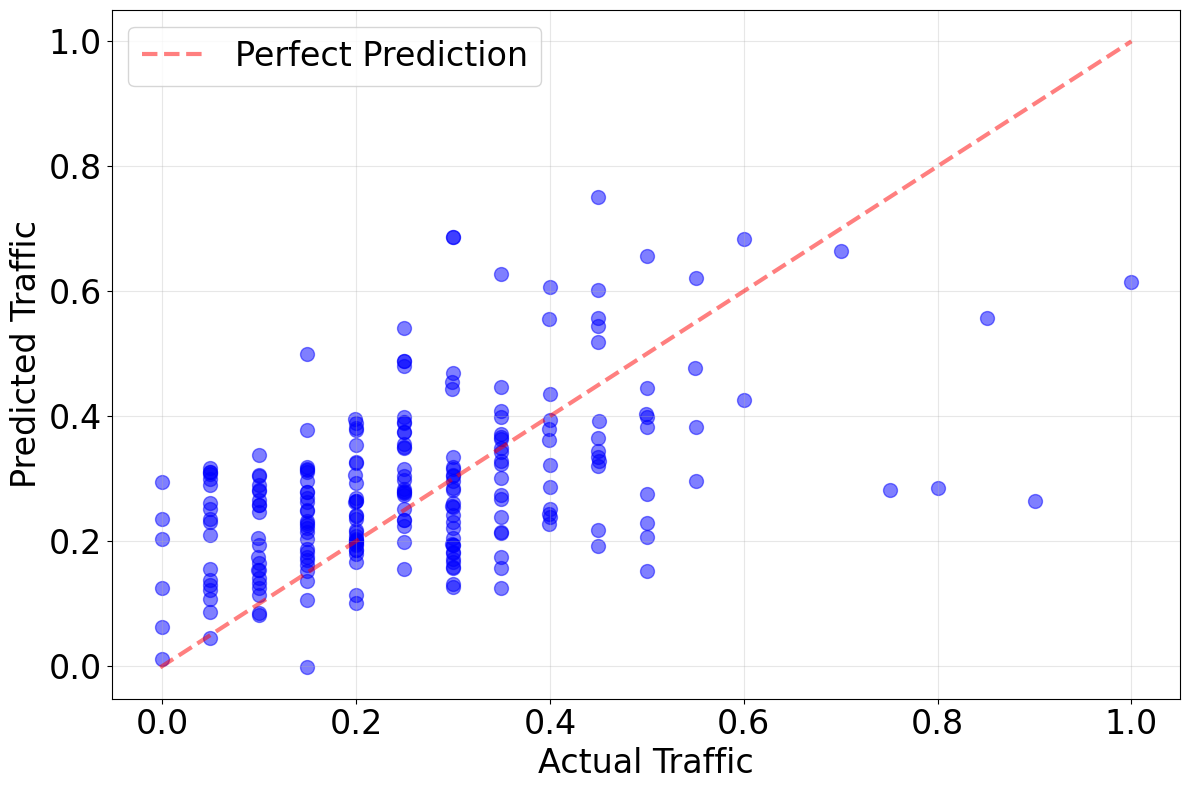

In [ ]:
# Plot the residuals
plot_actual_vs_predicted(y_test, y_test_pred)
plt.savefig('actual_vs_predicted_plot.png', dpi=300, bbox_inches='tight')
plt.close()

Identifying Optimal Number of Data Points

Running Linear Regression for test_size=0.1
--------EVALUATION---------------
Test Size: 0.1
Train MSE: 0.015550110559028846
Test MSE: 0.018190779854234652
Train RMSE: 0.12470008243392963
Test RMSE: 0.13487319916957058
Train MAE: 0.09480176738987865
Test MAE: 0.09105890053073946
----------------------------------------------

Running Linear Regression for test_size=0.2
--------EVALUATION---------------
Test Size: 0.2
Train MSE: 0.015678746241063968
Test MSE: 0.0167089767447742
Train RMSE: 0.1252148004073958
Test RMSE: 0.12926320723536996
Train MAE: 0.09399656888325396
Test MAE: 0.0994959724352119
----------------------------------------------

Running Linear Regression for test_size=0.30000000000000004
--------EVALUATION---------------
Test Size: 0.30000000000000004
Train MSE: 0.014099429618728954
Test MSE: 0.021821880452540358
Train RMSE: 0.11874101910767379
Test RMSE: 0.14772230858113597
Train MAE: 0.08686646741957209
Test MAE: 0.11383999579911748
------------------------------------

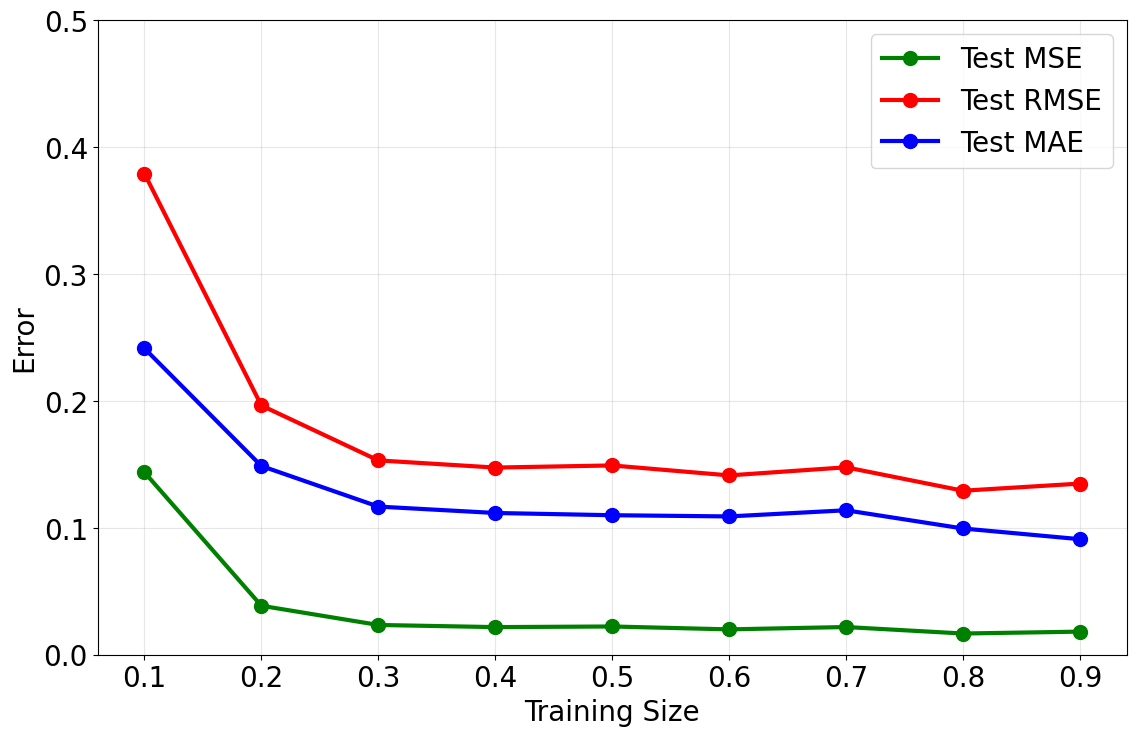

In [ ]:
# Define test sizes to iterate over
test_sizes = np.linspace(0.1, 0.9, 9)

# Call the method to find optimal training size and calculate metrics
train_sizes_list, test_mse_list, test_rmse_list, test_mae_list = find_optimal_training_size(X_combined, y_combined, test_sizes)
save_metrics_to_csv(train_sizes_list, test_mse_list, test_rmse_list, test_mae_list, filename='optimal_training_size_results.csv')

# Call the method to plot the results
plot_training_size_vs_errors(train_sizes_list, test_mse_list, test_rmse_list, test_mae_list)

Feature Contribution

In [ ]:
X_combined.columns

Index(['ShortestPathLength_x', 'ShortestPathLengthHops_x', 'NodeDegreeA_x',
       'NodeDegreeB_x', 'NodeBetweenessA_x', 'NodeBetweenessB_x',
       'fibre_edge_embedding', 'NodeDegreeProduct',
       'BinomialExpressionNodeDegreeAB', 'LatA', 'LongA', 'LatB', 'LongB',
       'isConnectedWithFibre', 'NumDCatA', 'NumDCatB', 'NumIXPatA',
       'NumIXPatB', 'PopulationA', 'PopulationB', 'ShortestPathLength_y',
       'ShortestPathLengthHops_y', 'NodeDegreeA_y', 'NodeDegreeB_y',
       'NodeBetweenessA_y', 'NodeBetweenessB_y', 'HaversineDistance',
       'edge_embedding'],
      dtype='object')

In [ ]:
# Get feature importance
df_feature_importance = get_feature_importance(X_combined, y_combined)
print(df_feature_importance)

                           feature    importance
27                  edge_embedding  4.645417e-01
4                NodeBetweenessA_x  3.984591e-01
16                       NumIXPatA  1.056269e-01
17                       NumIXPatB  7.297940e-02
2                    NodeDegreeA_x  4.198264e-02
1         ShortestPathLengthHops_x  3.821068e-02
6             fibre_edge_embedding  3.534738e-02
3                    NodeDegreeB_x  3.509638e-02
23                   NodeDegreeB_y  1.638627e-02
10                           LongA  1.612890e-02
12                           LongB  1.190875e-02
9                             LatA  9.273882e-03
22                   NodeDegreeA_y  7.447075e-03
26               HaversineDistance  3.950934e-04
8   BinomialExpressionNodeDegreeAB  3.310374e-04
18                     PopulationA  1.021611e-08
13            isConnectedWithFibre  1.692108e-13
21        ShortestPathLengthHops_y -1.554312e-15
20            ShortestPathLength_y -5.773160e-15
19                  

Top 10 Features

In [ ]:
# Top 10 - Top 5 from highest +ve and highest -ve
top_5_combined = get_top_5_features(df_feature_importance)
print(top_5_combined)

              feature  importance
27     edge_embedding    0.464542
4   NodeBetweenessA_x    0.398459
16          NumIXPatA    0.105627
17          NumIXPatB    0.072979
2       NodeDegreeA_x    0.041983
7   NodeDegreeProduct   -0.003789
11               LatB   -0.005266
5   NodeBetweenessB_x   -0.037231
24  NodeBetweenessA_y   -0.620958
25  NodeBetweenessB_y   -2.471503


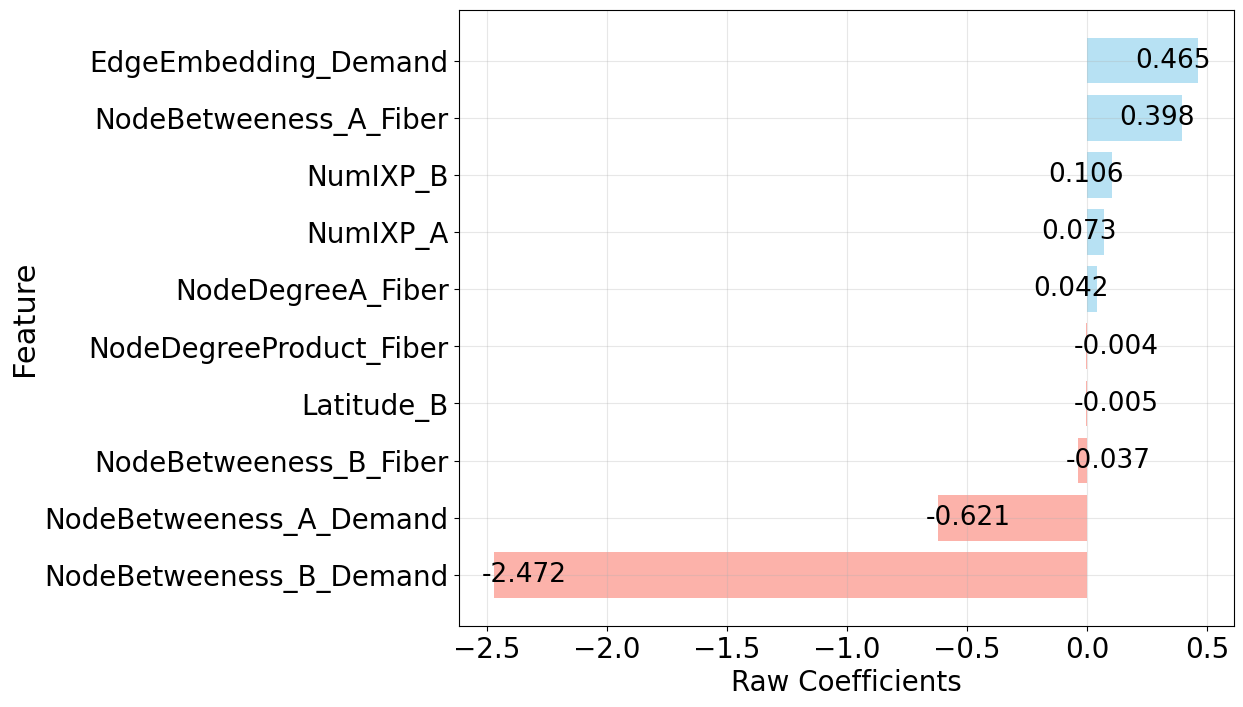

In [ ]:
# Create reader friendly labels
top_5_combined['feature'] = [ "EdgeEmbedding_Demand",
                              "NodeBetweeness_A_Fiber",
                              "NumIXP_B",
                              "NumIXP_A",
                              "NodeDegreeA_Fiber",
                              "NodeDegreeProduct_Fiber",
                              "Latitude_B",
                              "NodeBetweeness_B_Fiber",
                              "NodeBetweeness_A_Demand",
                              "NodeBetweeness_B_Demand"]

# Plot the feature analysis
plot_feature_importance(top_5_combined)

Rank Features based on Absolute values and find optimal number of features - top k

In [ ]:
# Rank the features by absolute importance (descending)
df_ranked = rank_features_by_absolute_importance(top_5_combined)
print(df_ranked)


                    feature  importance
25  NodeBetweeness_B_Demand   -2.471503
24  NodeBetweeness_A_Demand   -0.620958
27     EdgeEmbedding_Demand    0.464542
4    NodeBetweeness_A_Fiber    0.398459
16                 NumIXP_B    0.105627
17                 NumIXP_A    0.072979
2         NodeDegreeA_Fiber    0.041983
5    NodeBetweeness_B_Fiber   -0.037231
11               Latitude_B   -0.005266
7   NodeDegreeProduct_Fiber   -0.003789


In [ ]:
def create_feature_subsets(X_combined, final_data_demand_graph):
    """
    Creates incremental subsets of the most important features from the combined feature set.

    Parameters:
    - X_combined: The combined input feature matrix.
    - final_data_demand_graph: The DataFrame containing the target variable ('NormalisedTotalTraffic').

    Returns:
    - X_top_list: A list of DataFrames, each containing a subset of the most important features.
    - y: The target variable ('NormalisedTotalTraffic') from the demand graph data.
    """
    # Create feature subsets
    X_top_1 = X_combined[['NodeBetweenessB_y']]
    X_top_2 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y']]
    X_top_3 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y', 'edge_embedding']]
    X_top_4 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y', 'edge_embedding', 'NodeBetweenessA_x']]
    X_top_5 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y', 'edge_embedding', 'NodeBetweenessA_x', 'NumIXPatB']]
    X_top_6 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y', 'edge_embedding', 'NodeBetweenessA_x', 'NumIXPatB', 'NumIXPatA']]
    X_top_7 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y', 'edge_embedding', 'NodeBetweenessA_x', 'NumIXPatB', 'NumIXPatA', 'NodeDegreeA_x']]
    X_top_8 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y', 'edge_embedding', 'NodeBetweenessA_x', 'NumIXPatB', 'NumIXPatA', 'NodeDegreeA_x', 'NodeBetweenessB_x']]
    X_top_9 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y', 'edge_embedding', 'NodeBetweenessA_x', 'NumIXPatB', 'NumIXPatA', 'NodeDegreeA_x', 'NodeBetweenessB_x', 'LatB']]
    X_top_10 = X_combined[['NodeBetweenessB_y', 'NodeBetweenessA_y', 'edge_embedding', 'NodeBetweenessA_x', 'NumIXPatB', 'NumIXPatA', 'NodeDegreeA_x', 'NodeBetweenessB_x', 'LatB', 'NodeDegreeProduct']]

    # List of all X_top_k datasets from X_top_1 to X_top_10
    X_top_list = [X_top_1, X_top_2, X_top_3, X_top_4, X_top_5, X_top_6, X_top_7, X_top_8, X_top_9, X_top_10]

    # Target variable
    y = final_data_demand_graph['NormalisedTotalTraffic']

    return X_top_list, y

# Find minimal subset of features for comparable performance
X_top_list, y = create_feature_subsets(X_combined, final_data_demand_graph)


Find minimal subset of features for comparable performance


Running Linear Regression for X_top_1
Test MSE for X_top_1: 0.025125586005391685
Test RMSE for X_top_1: 0.15851052332697563
Test MAE for X_top_1: 0.1214987750045776
----------------------------------------------
Running Linear Regression for X_top_2
Test MSE for X_top_2: 0.025264762461445146
Test RMSE for X_top_2: 0.15894893035640456
Test MAE for X_top_2: 0.12236467781736553
----------------------------------------------
Running Linear Regression for X_top_3
Test MSE for X_top_3: 0.02098186687290952
Test RMSE for X_top_3: 0.14485118871762676
Test MAE for X_top_3: 0.11399780164168956
----------------------------------------------
Running Linear Regression for X_top_4
Test MSE for X_top_4: 0.019633827653159894
Test RMSE for X_top_4: 0.14012076096410514
Test MAE for X_top_4: 0.10911018945320508
----------------------------------------------
Running Linear Regression for X_top_5
Test MSE for X_top_5: 0.019839936843572784
Test RMSE for X_top_5: 0.14085431070284213
Test MAE for X_top_5: 0.10

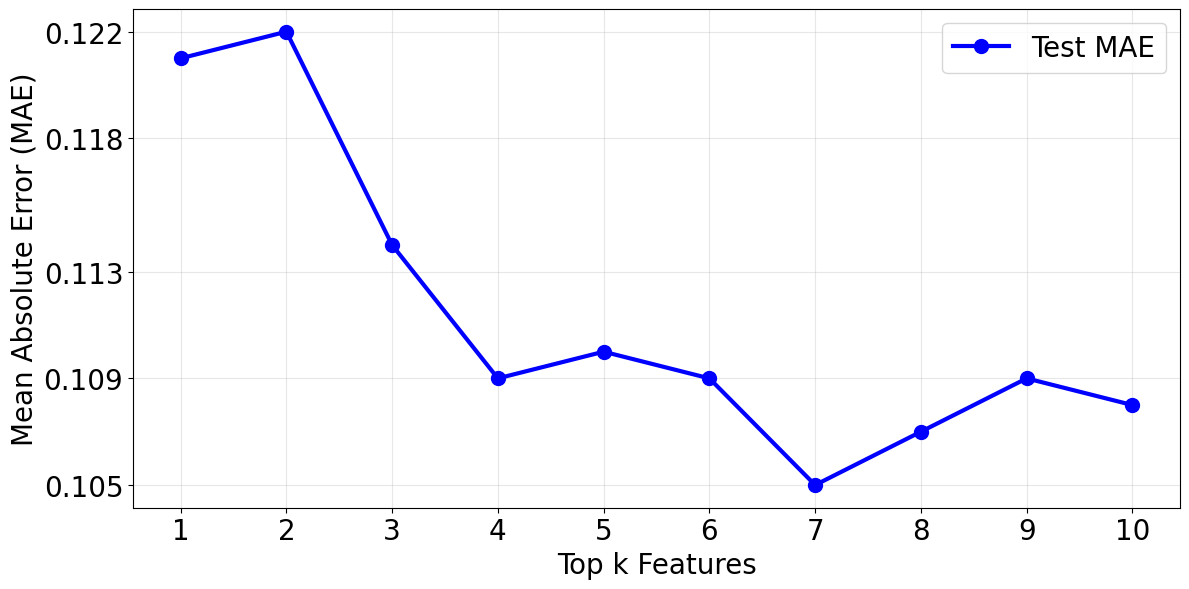

In [ ]:
# Assuming X_top_list and y are already defined
test_mse_list, test_rmse_list, test_mae_list = calculate_optimal_feature_metrics(X_top_list, y)

# Plot the results
plot_optimal_feature_metrics(test_mae_list)

Baseline

In [ ]:
# Get baselines predictions
final_data_with_baseline_predictions = process_baseline_predictions(final_data_fibre_graph, y)
# Example usage:
compute_and_print_metrics(final_data_with_baseline_predictions)

NaN values in OFC traffic: 0
Infinite values in OFC traffic: 1
NaN values in ECOC traffic: 0
Infinite values in ECOC traffic: 0
Baseline values for OFC model
-----------------------------
MSE: 0.09249602804634104, RMSE: 0.30413159659321987, MAE: 0.25371535866631084
-----------------------------
Baseline values for Mean model
-----------------------------
MSE: 0.028436609792584853, RMSE: 0.16863158005719112, MAE: 0.12744750999520232
-----------------------------
Baseline values for Median model
-----------------------------
MSE: 0.028596317731452874, RMSE: 0.16910445804724628, MAE: 0.1250755370755371
-----------------------------
Baseline values for ECOC model
-----------------------------
MSE: 0.09417359371506152, RMSE: 0.3068771638865648, MAE: 0.2548867618469389
-----------------------------


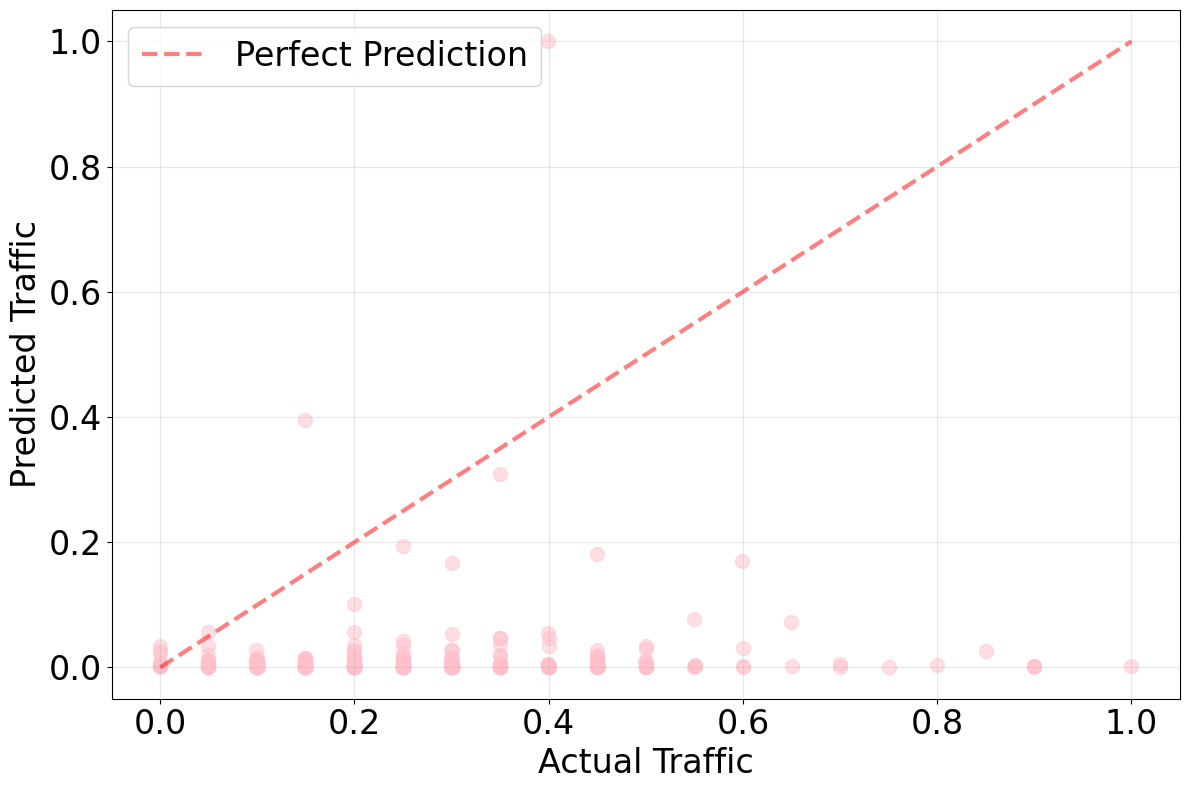

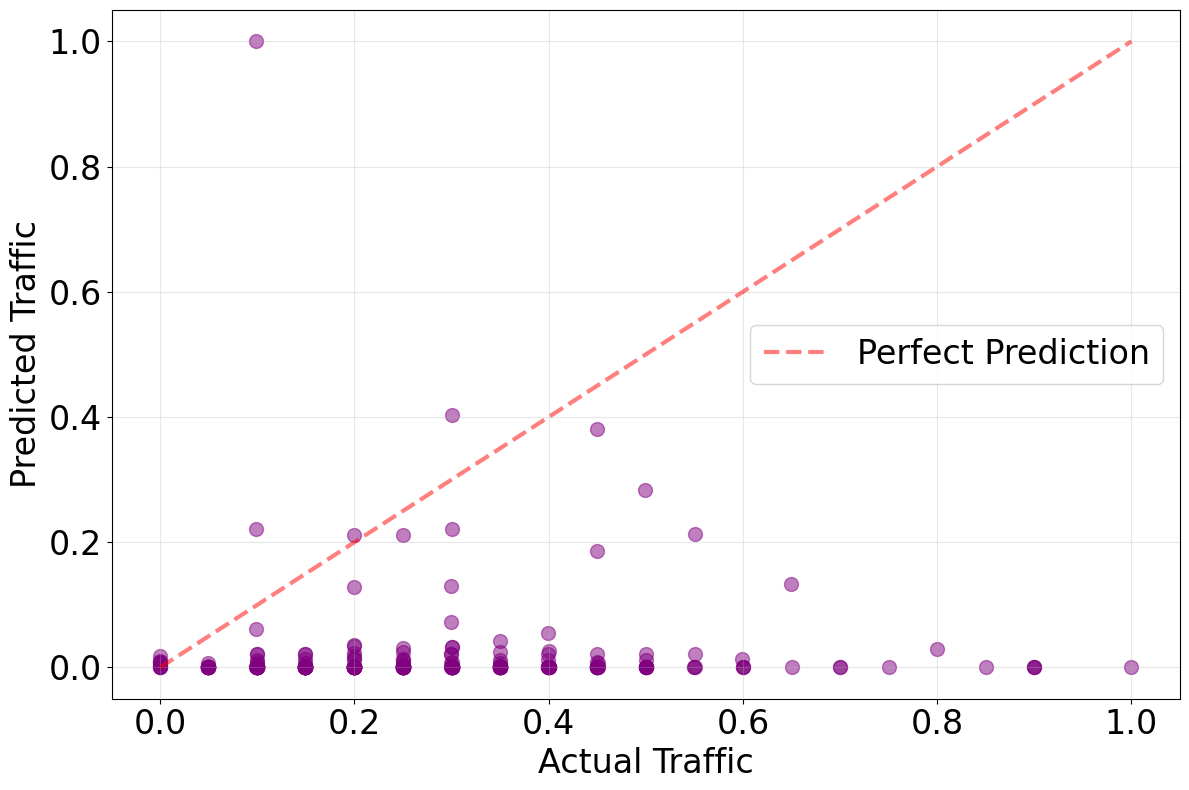

In [ ]:
# Assuming y_test and y_pred are already calculated
plot_actual_vs_predicted(final_data_with_baseline_predictions['NormalisedTotalTraffic'],
                         final_data_with_baseline_predictions['Normalized_OFC_traffic_population_product_divided_by_distance'], color='pink')

plot_actual_vs_predicted(final_data_with_baseline_predictions['NormalisedTotalTraffic'],
                         final_data_with_baseline_predictions['Normalized_ECOC_traffic'],color='purple')


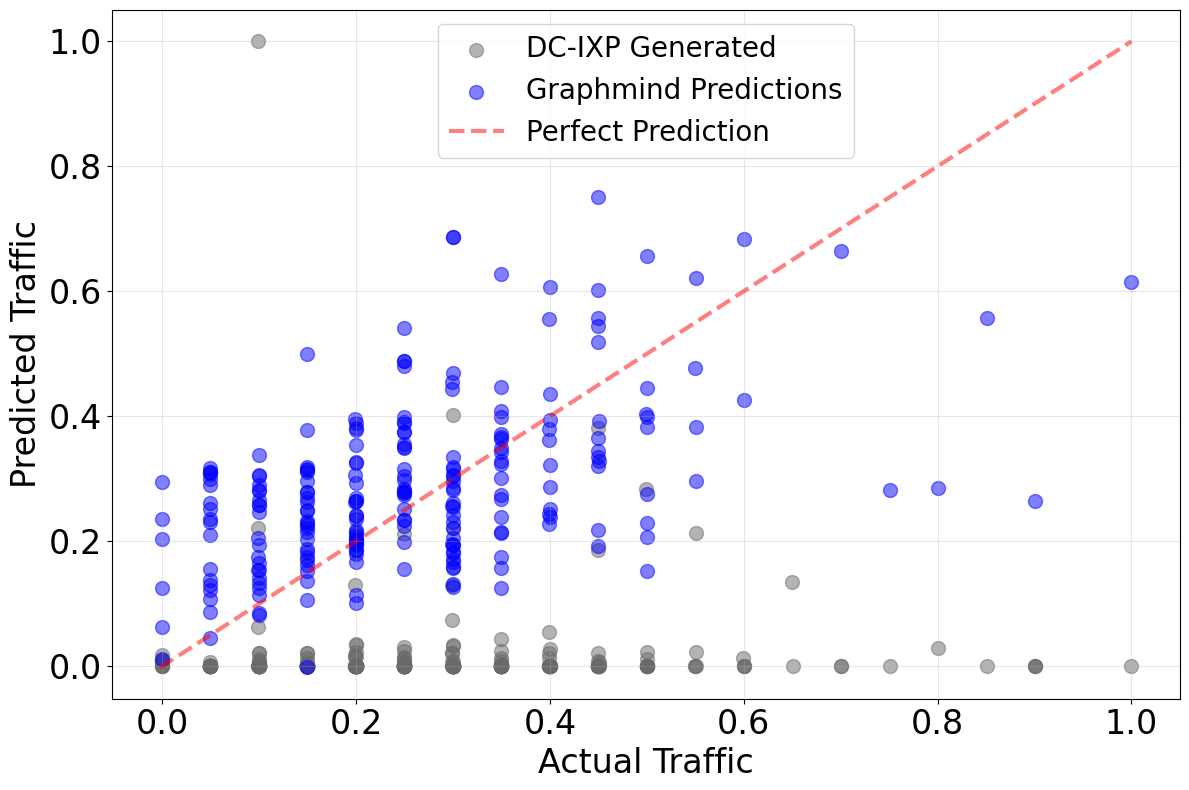

In [ ]:
# Assuming 'final_data_with_baseline_predictions' has the actual and predicted values
plot_actual_vs_predicted_both_models(
    final_data_with_baseline_predictions['NormalisedTotalTraffic'],  # y_true_baseline
    final_data_with_baseline_predictions['Normalized_ECOC_traffic'], # y_pred_baseline
    graphmind_lr_test_output,  # y_true_graphmind
    graphmind_lr_test_pred  # y_pred_graphmind
)



Classification of high and low traffic

Running Logistic Regression with test size 0.1
Minority Class (label=1) Accuracy: 0.0
----------------------------------------------
Running Logistic Regression with test size 0.2
Minority Class (label=1) Accuracy: 0.0
----------------------------------------------
Running Logistic Regression with test size 0.30000000000000004
Minority Class (label=1) Accuracy: 0.0
----------------------------------------------
Running Logistic Regression with test size 0.4
Minority Class (label=1) Accuracy: 0.0
----------------------------------------------
Running Logistic Regression with test size 0.5
Minority Class (label=1) Accuracy: 0.14285714285714285
----------------------------------------------
Running Logistic Regression with test size 0.6
Minority Class (label=1) Accuracy: 0.14285714285714285
----------------------------------------------
Running Logistic Regression with test size 0.7000000000000001
Minority Class (label=1) Accuracy: 0.125
----------------------------------------------
Runn

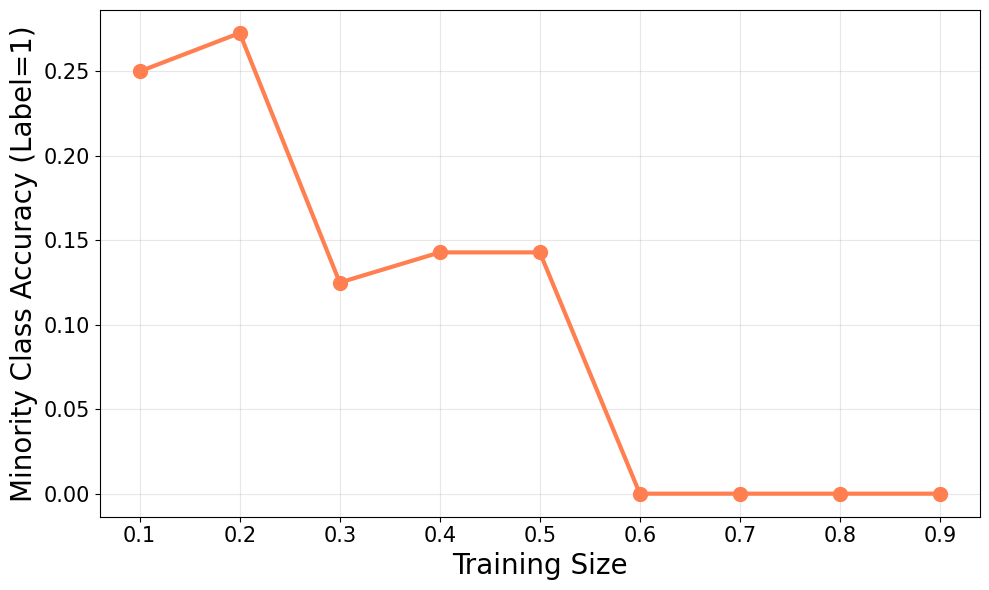

In [ ]:
# Extract and scale features
X_scaled = extract_and_scale_features_graphmind_cl(final_data_fibre_graph, final_data_demand_graph)

# Prepare binary target variable
y_binary = prepare_target_variable_graphmind_cl(final_data_demand_graph)

# Run logistic regression and get accuracy results
train_sizes, minority_class_accuracy_list = run_logistic_regression_graphmind_cl(X_scaled, y_binary)

# Plot the minority class accuracy against training sizes
plot_minority_class_accuracy(train_sizes, minority_class_accuracy_list)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Threshold: 0.1
Total Accuracy: 0.6666666666666666
Minority Class Accuracy (label=1): 1.0
Majority Class Accuracy (label=0): 0.5
-------------------------------------------
Threshold: 0.2
Total Accuracy: 0.75
Minority Class Accuracy (label=1): 1.0
Majority Class Accuracy (label=0): 0.625
-------------------------------------------
Threshold: 0.30000000000000004
Total Accuracy: 0.75
Minority Class Accuracy (label=1): 0.75
Majority Class Accuracy (label=0): 0.75
-------------------------------------------
Threshold: 0.4
Total Accuracy: 0.8333333333333334
Minority Class Accuracy (label=1): 0.75
Majority Class Accuracy (label=0): 0.875
-------------------------------------------
Threshold: 0.5
Total Accuracy: 0.8333333333333334
Minority Class Accuracy (label=1): 0.5
Majority Class Accuracy (label=0): 1.0
-------------------------------------------
Threshold: 0.6
Total Accuracy: 0.8333333333333334
Minority Class Accuracy (label=1): 0.5
Majority Class Accuracy (label=0): 1.0
-----------------

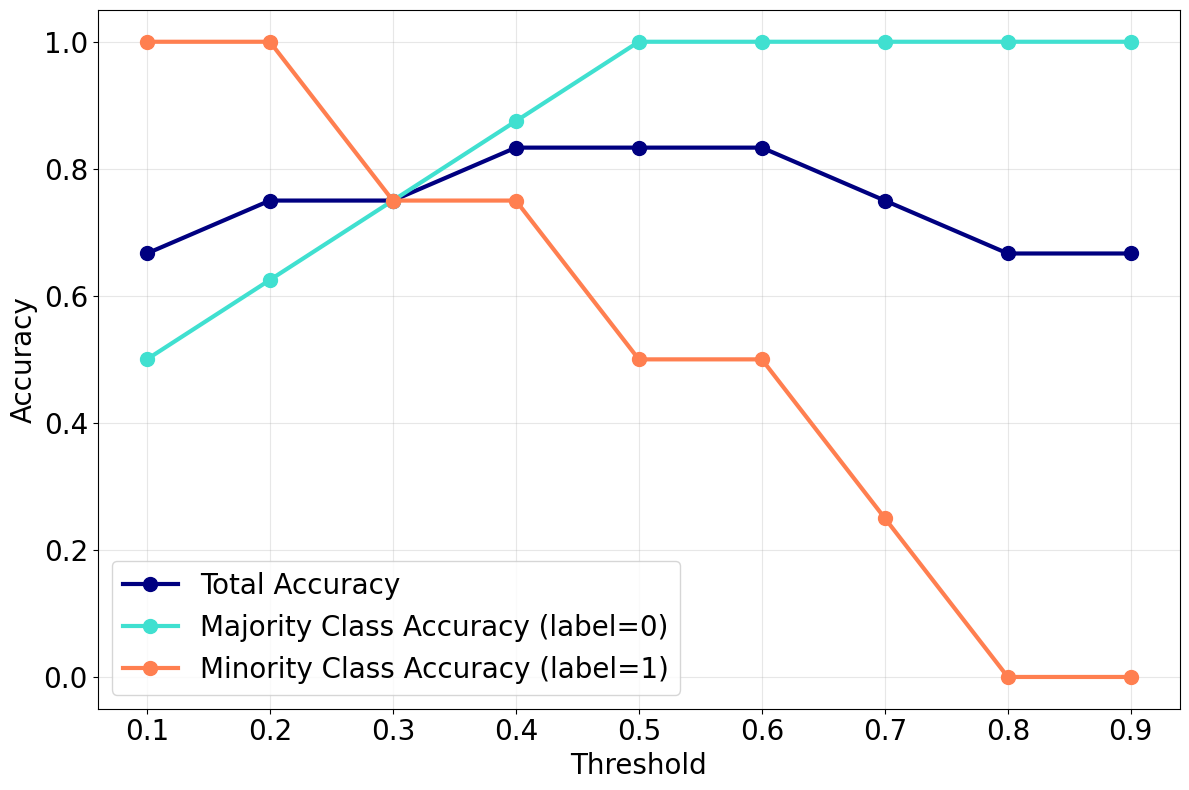

In [ ]:
# Step 1: Separate dataset into two groups
data_0, data_1 = separate_dataset_graphmind_cl(X_combined, y_binary)

# Step 2: Create train and test sets
X_train, y_train, X_test, y_test = create_train_test_sets_graphmind_cl(data_0, data_1)

# Step 3: Train logistic regression model and predict probabilities
y_prob = train_logistic_regression_graphmind_cl(X_train, y_train, X_test)

# Step 4: Evaluate model across thresholds
thresholds, total_accuracy_list, minority_class_accuracy_list, majority_class_accuracy_list = evaluate_thresholds_graphmind_cl(y_test, y_prob)

# Step 5: Plot the accuracies
plot_accuracies_graphmind_cl(thresholds, total_accuracy_list, minority_class_accuracy_list, majority_class_accuracy_list)


Distribution of Traffic

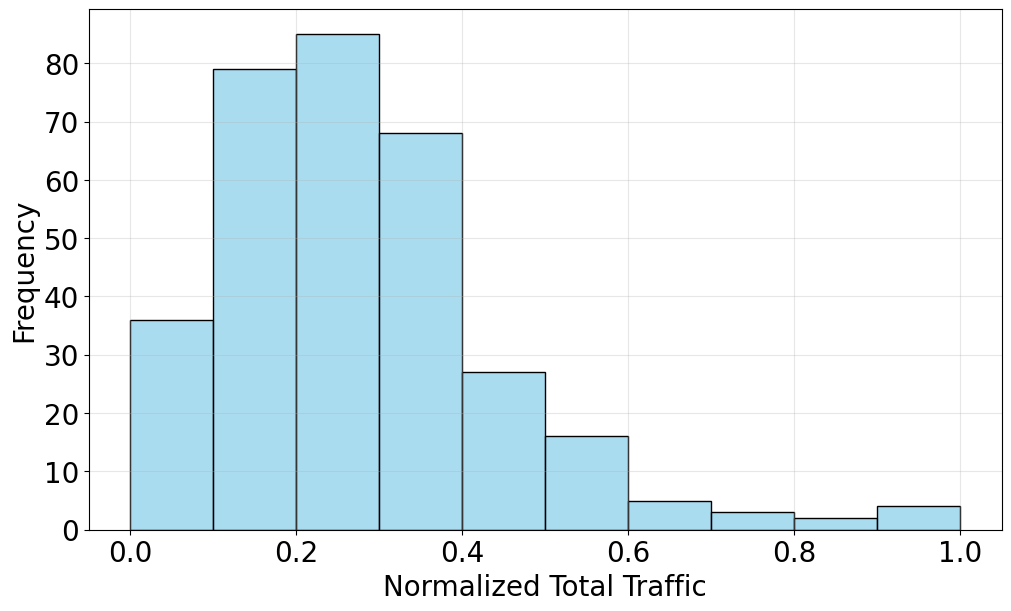

In [ ]:
distribution_of_total_normalised_demand_graphmind_cl(final_data_demand_graph['NormalisedTotalTraffic'])

Multi Output Regression Model

In [ ]:
# Predicting both inflow and outflow
y_outflow, y_inflow = process_inflow_outflow_from_csv_graphmind_mlr("/content/raw_traffic_bt_sorted.csv")
predict_inflow_outflow_graphmind_mlr(X_combined, y_outflow, y_inflow)

--------------------------------------------------
Multi Output Model Predictions: Linear Regression
--------------------------------------------------
MSE for Outflow: 0.024151182321130903
MSE for Inflow: 0.02396380384676625
--------------------------------------------------
MAE for Outflow: 0.12259134121929156
MAE for Inflow: 0.11986989087138882
--------------------------------------------------
RMSE for Outflow: 0.1554065066885261
RMSE for Inflow: 0.15480246718565646
--------------------------------------------------


Running for test size: 0.1
Test Size: 0.1
MSE for Outflow: 0.018283874155383847
MSE for Inflow: 0.013073667235696973
MAE for Outflow: 0.10709371656055412
MAE for Inflow: 0.08906855597088933
RMSE for Outflow: 0.1352178766117256
RMSE for Inflow: 0.11434013834037884
--------------------------------------------------
Running for test size: 0.2
Test Size: 0.2
MSE for Outflow: 0.01671772093109638
MSE for Inflow: 0.011870966988450669
MAE for Outflow: 0.10561799242964785
MAE for Inflow: 0.08994267350373782
RMSE for Outflow: 0.12929702599478604
RMSE for Inflow: 0.10895396729101088
--------------------------------------------------
Running for test size: 0.30000000000000004
Test Size: 0.30000000000000004
MSE for Outflow: 0.01877151355092162
MSE for Inflow: 0.017541210012296873
MAE for Outflow: 0.10863699426806644
MAE for Inflow: 0.10082317518883487
RMSE for Outflow: 0.1370091732363991
RMSE for Inflow: 0.13244323316914636
--------------------------------------------------
Running for test size: 0

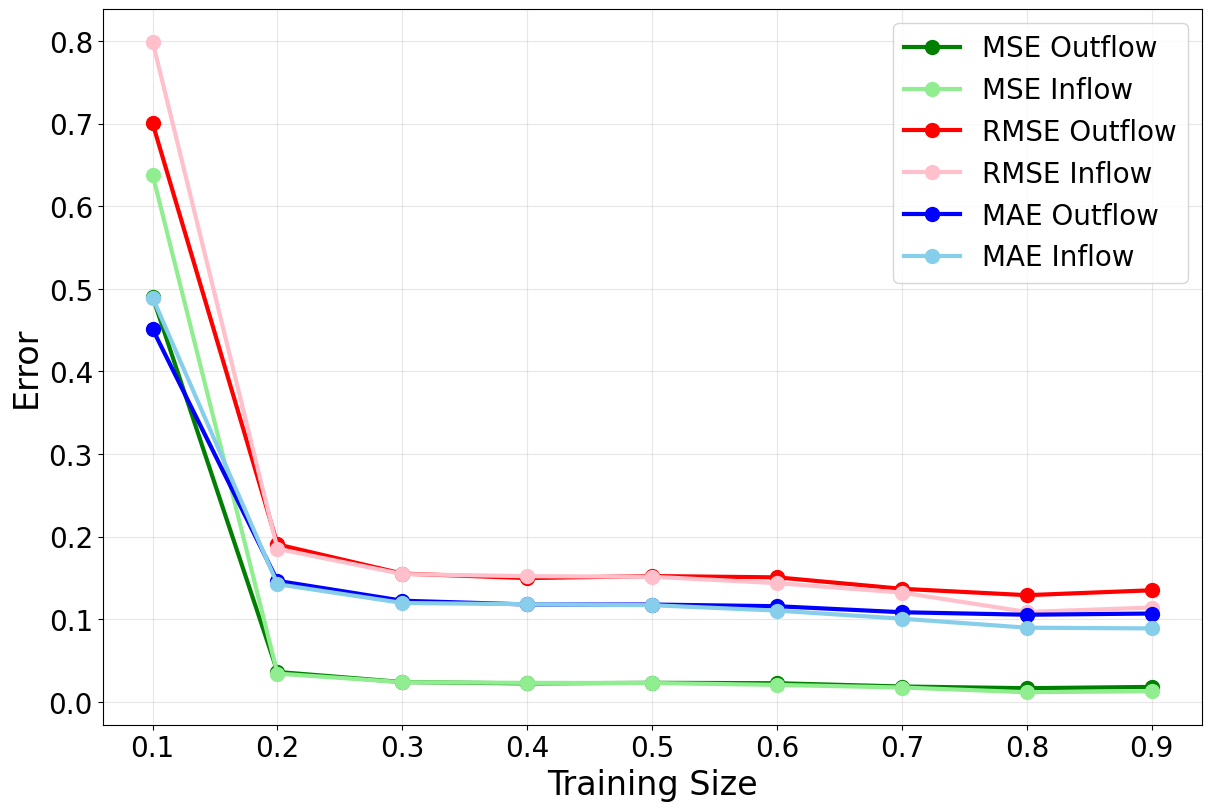

In [ ]:
X_features = X_combined

y_targets = pd.DataFrame({
   'outflow': y_outflow,
   'inflow': y_inflow
})


# Step 1: Evaluate the multi-output model and get the results
train_sizes, mse_outflow_list, mse_inflow_list, mae_outflow_list, mae_inflow_list, rmse_outflow_list, rmse_inflow_list = evaluate_multi_output_model_graphmind_mlr(X_features, y_targets)

# Step 2: Plot the evaluation metrics
plot_evaluation_metrics_graphmind_mlr(train_sizes, mse_outflow_list, mse_inflow_list, mae_outflow_list, mae_inflow_list, rmse_outflow_list, rmse_inflow_list)


Compute Asymmetric Score

In [ ]:
asymmetry_scores = calculate_asymmetry_scores_graphmind(y_inflow, y_outflow)

Asymmetry Scores:
     Relative_Difference
0               0.499250
1               0.200000
2               0.712082
3               0.538036
4               0.249438
..                   ...
320             0.712082
321             0.201439
322             0.497758
323             0.000000
324             0.332000

[325 rows x 1 columns]


In [ ]:
asymmetry_scores['Relative_Difference'].describe()

,Relative_Difference
count,325.000000
mean,0.528264
std,0.227098
min,0.000000
25%,0.333333
50%,0.597122
75%,0.712082
max,0.845090


In [ ]:
!pip list
!pip freeze > requirements.txt


Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         0.34.2
aiohappyeyeballs                   2.4.3
aiohttp                            3.10.10
aiosignal                          1.3.1
alabaster                          0.7.16
albucore                           0.0.16
albumentations                     1.4.15
altair                             4.2.2
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.19.0
astropy                            6.1.4
astropy-iers-data                  0.2024.10.21.0.33.21
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.2.0
audioread      

In [ ]:
!python --version

Python 3.10.12
